In [2]:
path = "/Users/joshuafass/Documents/MSKCC/Chodera Lab/feedstock/FreeSolv-0.51/database.txt"
from pickle import load
with open(path, 'r') as f:
    freesolv = f.read()
from tqdm import tqdm

In [3]:
legend = freesolv.split('\n')[2].split('; ')
print(list(zip(range(len(legend)), legend)))

[(0, '# compound id (and file prefix)'), (1, 'SMILES'), (2, 'iupac name (or alternative if IUPAC is unavailable or not parseable by OEChem)'), (3, 'experimental value (kcal/mol)'), (4, 'experimental uncertainty (kcal/mol)'), (5, 'Mobley group calculated value (GAFF) (kcal/mol)'), (6, 'calculated uncertainty (kcal/mol)'), (7, 'experimental reference (original or paper this value was taken from)'), (8, 'calculated reference'), (9, 'text notes.')]


In [4]:
db = []
for entry in freesolv.split('\n')[3:-1]:
    db.append(entry.split('; '))

In [5]:
smiles_list = [entry[1] for entry in db]

In [6]:
sorted(smiles_list, key=len)

['S',
 'N',
 'C',
 'CO',
 'CC',
 'CI',
 'CS',
 'CN',
 'NN',
 'CF',
 'CCI',
 'CCS',
 'CCC',
 'C=O',
 'CCO',
 'CCN',
 'CCl',
 'CNC',
 'C=C',
 'COC',
 'CBr',
 'CSC',
 'CCCI',
 'CCCS',
 'CCCC',
 'CC=O',
 'CCSC',
 'CCCl',
 'CC=C',
 'CCCO',
 'CCOC',
 'CC#N',
 'CSSC',
 'CC#C',
 'CCCN',
 'CCBr',
 'CCCCO',
 'CCOCC',
 'CCCCS',
 'CCC=C',
 'COC=O',
 'CCCCl',
 'CCCOC',
 'C1CC1',
 'COCOC',
 'CCC#N',
 'CCSCC',
 'CCCCC',
 'COCCO',
 'C=CCl',
 'CCC=O',
 'C(I)I',
 'COCCN',
 'CCCBr',
 'C=CCO',
 'CCNCC',
 'CCCCI',
 'CCC#C',
 'CCCCN',
 'CC(C)I',
 'CCOC=O',
 'CCCCBr',
 'CC(F)F',
 'C(F)Cl',
 'CCCCCl',
 'CCCC=C',
 'CCCC#C',
 'COCCOC',
 'C(CO)O',
 'C=CC=C',
 'CC(C)C',
 'CCCCCO',
 'CCSSCC',
 'C1CNC1',
 'CCCCCC',
 'C=CCCl',
 'CCCCCN',
 'CC(C)O',
 'CCCC#N',
 'CCCCCI',
 'CCCC=O',
 'CN(C)C',
 'CCOCCO',
 'CC(C)Cl',
 'CCCCC#C',
 'CCC(C)C',
 'CCCCCCl',
 'CC(C)CO',
 'CCCNCCC',
 'c1ccsc1',
 'CC(=C)C',
 'CC(=O)O',
 'CC(C)OC',
 'CCCCCCO',
 'CCCCCBr',
 'C(Cl)Cl',
 'CC(=O)C',
 'CCCOCCO',
 'CCCCC#N',
 'CCCSCCC',
 'CCCCC=C',
 

In [7]:
import openeye

In [8]:
from openeye import oeomega  # Omega toolkit
omega = oeomega.OEOmega()
#omega.SetMaxConfs(800)  # Best-practice? Expensive...
omega.SetMaxConfs(10)
omega.SetIncludeInput(False)
omega.SetStrictStereo(True)  # Refuse to generate conformers if stereochemistry not provided

from openforcefield.typing.engines.smirnoff import ForceField, generateTopologyFromOEMol
from openeye import oechem  # OpenEye Python toolkits

from openeye import oequacpac  # Charge toolkit

ff = ForceField('forcefield/smirnoff99Frosst.offxml')

def generate_oemol(smiles):
    """Add hydrogens, assign charges, generate conformers, and return molecule"""
    mol = oechem.OEMol()
    chargeEngine = oequacpac.OEAM1BCCCharges()
    oechem.OEParseSmiles(mol, smiles)
    oechem.OEAddExplicitHydrogens(mol)
    status = omega(mol)
    if not status: print("Something went wrong in `generate_oemol({})!".format(smiles))
    oechem.OETriposAtomNames(mol)
    oequacpac.OESetNeutralpHModel(mol)
    oequacpac.OEAssignCharges(mol, chargeEngine)
    _ = generateTopologyFromOEMol(mol)
    return mol


def generate_mol_top_sys_pos(smiles):
    """Generate an openmm topology, openmm system, and coordinate array from a smiles string"""
    print(smiles)
    mol = generate_oemol(smiles)

    coord_dict = mol.GetCoords()
    positions = np.array([coord_dict[key] for key in coord_dict])

    topology = generateTopologyFromOEMol(mol)

    system = ff.createSystem(topology, [mol])

    return mol, topology, system, positions

In [9]:
sorted_smiles = sorted(list(set(smiles_list)), key=len)[::-1]

In [10]:
from tqdm import tqdm
import numpy as np
mol_top_sys_pos_list = []

for smiles in tqdm(sorted_smiles):
    mol_top_sys_pos_list.append(tuple(generate_mol_top_sys_pos(smiles)))

  0%|          | 0/642 [00:00<?, ?it/s]

C1[C@@H]2[C@H]3[C@@H]([C@H]1[C@H]4[C@@H]2O4)[C@@]5(C(=C([C@]3(C5(Cl)Cl)Cl)Cl)Cl)Cl


  0%|          | 1/642 [00:01<13:38,  1.28s/it]

C1[C@H]([C@@H]2[C@H]([C@H]1Cl)[C@]3(C(=C([C@@]2(C3(Cl)Cl)Cl)Cl)Cl)Cl)Cl


  0%|          | 2/642 [00:01<10:24,  1.02it/s]

C1=C[C@@H]([C@@H]2[C@H]1[C@@]3(C(=C([C@]2(C3(Cl)Cl)Cl)Cl)Cl)Cl)Cl


  0%|          | 3/642 [00:02<09:01,  1.18it/s]

C1[C@@H]2[C@H](COS(=O)O1)[C@@]3(C(=C([C@]2(C3(Cl)Cl)Cl)Cl)Cl)Cl


  1%|          | 4/642 [00:04<11:59,  1.13s/it]

CCC[N@@](CC1CC1)c2c(cc(cc2[N+](=O)[O-])C(F)(F)F)[N+](=O)[O-]


  1%|          | 5/642 [00:27<57:45,  5.44s/it]

CCCC[N@](CC)c1c(cc(cc1[N+](=O)[O-])C(F)(F)F)[N+](=O)[O-]


  1%|          | 6/642 [00:41<1:13:52,  6.97s/it]

CCCN(CCC)c1c(cc(cc1[N+](=O)[O-])S(=O)(=O)C)[N+](=O)[O-]


  1%|          | 7/642 [01:01<1:32:25,  8.73s/it]

c1(c(c(c(c(c1Cl)Cl)Cl)Cl)Cl)c2c(c(c(c(c2Cl)Cl)Cl)Cl)Cl


  1%|          | 8/642 [01:02<1:21:55,  7.75s/it]

CCN(CC)c1c(cc(c(c1[N+](=O)[O-])N)C(F)(F)F)[N+](=O)[O-]


  1%|▏         | 9/642 [01:15<1:28:39,  8.40s/it]

CCCN(CCC)c1c(cc(cc1[N+](=O)[O-])C(F)(F)F)[N+](=O)[O-]


  2%|▏         | 10/642 [01:37<1:42:14,  9.71s/it]

c12c(c(c(c(c1Cl)Cl)Cl)Cl)Oc3c(c(c(c(c3Cl)Cl)Cl)Cl)O2


  2%|▏         | 11/642 [01:38<1:33:45,  8.92s/it]

CC[C@@H](C)c1cc(cc(c1O)[N+](=O)[O-])[N+](=O)[O-]


  2%|▏         | 12/642 [01:45<1:32:16,  8.79s/it]

C([C@@H]1[C@H]([C@@H]([C@H]([C@@H](O1)O)O)O)O)O


  2%|▏         | 13/642 [01:46<1:26:09,  8.22s/it]

c1c(c(c(c(c1Cl)Cl)Cl)Cl)c2c(cc(c(c2Cl)Cl)Cl)Cl


  2%|▏         | 14/642 [01:48<1:21:04,  7.75s/it]

c1c2c(cc(c1Cl)Cl)Oc3c(c(c(c(c3Cl)Cl)Cl)Cl)O2


  2%|▏         | 15/642 [01:49<1:16:02,  7.28s/it]

C1C=CC[C@@H]2[C@@H]1C(=O)N(C2=O)SC(Cl)(Cl)Cl


  2%|▏         | 16/642 [01:49<1:11:37,  6.87s/it]

CCOP(=S)(OCC)S[C@@H](CCl)N1C(=O)c2ccccc2C1=O


  3%|▎         | 17/642 [02:11<1:20:46,  7.75s/it]

c1cc(c(c(c1c2cc(c(c(c2Cl)Cl)Cl)Cl)Cl)Cl)Cl


  3%|▎         | 18/642 [02:13<1:16:55,  7.40s/it]

c1c(cc(c(c1Cl)Cl)Cl)c2cc(c(c(c2Cl)Cl)Cl)Cl


  3%|▎         | 19/642 [02:13<1:12:56,  7.02s/it]

C([C@H]([C@H]([C@@H]([C@@H](CO)O)O)O)O)O


  3%|▎         | 20/642 [02:19<1:12:31,  7.00s/it]

c1cc2c(cc1Cl)Oc3c(c(c(c(c3Cl)Cl)Cl)Cl)O2


  3%|▎         | 21/642 [02:20<1:09:12,  6.69s/it]

c1ccc2c(c1)Oc3c(c(c(c(c3Cl)Cl)Cl)Cl)O2


  3%|▎         | 22/642 [02:20<1:06:07,  6.40s/it]

C[C@@H](c1cccc(c1)C(=O)c2ccccc2)C(=O)O


  4%|▎         | 23/642 [02:27<1:06:00,  6.40s/it]

c1cc(c(cc1c2cc(c(c(c2Cl)Cl)Cl)Cl)Cl)Cl


  4%|▎         | 24/642 [02:27<1:03:24,  6.16s/it]

CCOP(=O)(OCC)O/C(=C/Cl)/c1ccc(cc1Cl)Cl


  4%|▍         | 25/642 [02:39<1:05:42,  6.39s/it]

c1cc(c(cc1c2c(c(cc(c2Cl)Cl)Cl)Cl)Cl)Cl


  4%|▍         | 26/642 [02:40<1:03:17,  6.17s/it]

C[C@@H](CCO[N+](=O)[O-])O[N+](=O)[O-]


  4%|▍         | 27/642 [02:43<1:02:15,  6.07s/it]

C1[C@H]([C@@H]([C@H]([C@H](O1)O)O)O)O


  4%|▍         | 28/642 [02:44<1:00:13,  5.88s/it]

CCOC(=O)C[C@H](C(=O)OCC)SP(=S)(OC)OC


  5%|▍         | 29/642 [03:00<1:03:24,  6.21s/it]

C[C@@H](CO[N+](=O)[O-])O[N+](=O)[O-]


  5%|▍         | 30/642 [03:03<1:02:17,  6.11s/it]

c1cc(c(c(c1)Cl)c2c(cc(cc2Cl)Cl)Cl)Cl


  5%|▍         | 31/642 [03:03<1:00:18,  5.92s/it]

c1cc2c(cc1Cl)Oc3cc(c(c(c3O2)Cl)Cl)Cl


  5%|▍         | 32/642 [03:04<58:29,  5.75s/it]  

CCOP(=S)(OCC)Oc1ccc(cc1)[N+](=O)[O-]


  5%|▌         | 33/642 [03:12<59:03,  5.82s/it]

c1cc(c(cc1Cl)c2cc(c(c(c2)Cl)Cl)Cl)Cl


  5%|▌         | 34/642 [03:12<57:19,  5.66s/it]

C[C@@H](c1ccc(c(c1)F)c2ccccc2)C(=O)O


  5%|▌         | 35/642 [03:19<57:35,  5.69s/it]

c1c2c(cc(c1Cl)Cl)Oc3cc(c(cc3O2)Cl)Cl


  6%|▌         | 36/642 [03:19<56:04,  5.55s/it]

c1(c(c(c(c(c1Cl)Cl)Cl)Cl)Cl)N(=O)=O


  6%|▌         | 37/642 [03:20<54:39,  5.42s/it]

c1ccc2c(c1)C(=O)c3c(ccc(c3C2=O)O)N


  6%|▌         | 38/642 [03:21<53:18,  5.29s/it]

CCOP(=S)(OCC)Oc1c(cc(c(n1)Cl)Cl)Cl


  6%|▌         | 39/642 [03:29<54:01,  5.37s/it]

c1ccc2c(c1)C(=O)c3c(ccc(c3C2=O)N)N


  6%|▌         | 40/642 [03:30<52:43,  5.25s/it]

Cc1c(c(=O)n(c(=O)[nH]1)C(C)(C)C)Cl


  6%|▋         | 41/642 [03:31<51:35,  5.15s/it]

COP(=S)(OC)Oc1ccc(cc1)[N+](=O)[O-]


  7%|▋         | 42/642 [03:35<51:24,  5.14s/it]

c1ccc2c(c1)Oc3c(cc(c(c3O2)Cl)Cl)Cl


  7%|▋         | 43/642 [03:36<50:13,  5.03s/it]

CC[C@H](C)n1c(=O)c(c([nH]c1=O)C)Br


  7%|▋         | 44/642 [03:39<49:37,  4.98s/it]

c1ccc2c(c1)C(=O)c3cccc(c3C2=O)NCCO


  7%|▋         | 45/642 [03:44<49:36,  4.99s/it]

C[C@@H](c1ccc2cc(ccc2c1)OC)C(=O)O


  7%|▋         | 46/642 [03:51<49:58,  5.03s/it]

C[C@@H]1CC[C@H]([C@@H](C1)O)C(C)C


  7%|▋         | 47/642 [03:53<49:14,  4.97s/it]

c1cc(c(c(c1)Cl)c2c(cccc2Cl)Cl)Cl


  7%|▋         | 48/642 [03:53<48:14,  4.87s/it]

CCOP(=S)(OCC)Oc1cc(nc(n1)C(C)C)C


  8%|▊         | 49/642 [04:07<49:51,  5.05s/it]

CN(C)C(=O)c1ccc(cc1)[N+](=O)[O-]


  8%|▊         | 50/642 [04:08<48:57,  4.96s/it]

c1c(c(=O)[nH]c(=O)[nH]1)C(F)(F)F


  8%|▊         | 51/642 [04:08<47:58,  4.87s/it]

c1ccc(cc1)c2cc(c(c(c2Cl)Cl)Cl)Cl


  8%|▊         | 52/642 [04:08<47:01,  4.78s/it]

c1ccc2c(c1)C(=O)c3ccc(cc3C2=O)N


  8%|▊         | 53/642 [04:09<46:09,  4.70s/it]

C(CO[N+](=O)[O-])CO[N+](=O)[O-]


  8%|▊         | 54/642 [04:11<45:39,  4.66s/it]

c1ccc2c(c1)C(=O)c3cccc(c3C2=O)N


  9%|▊         | 55/642 [04:12<44:50,  4.58s/it]

c1cc(c(cc1c2ccc(cc2F)F)C(=O)O)O


  9%|▊         | 56/642 [04:16<44:42,  4.58s/it]

COP(=S)(OC)SCn1c(=O)c2ccccc2nn1


  9%|▉         | 57/642 [04:25<45:27,  4.66s/it]

C[C@@H](c1ccc(cc1)CC(C)C)C(=O)O


  9%|▉         | 58/642 [04:31<45:31,  4.68s/it]

c1ccc2c(c1)Oc3cc(c(cc3O2)Cl)Cl


  9%|▉         | 59/642 [04:31<44:43,  4.60s/it]

COP(=O)([C@H](C(Cl)(Cl)Cl)O)OC


  9%|▉         | 60/642 [04:34<44:23,  4.58s/it]

C(CO[N+](=O)[O-])O[N+](=O)[O-]


 10%|▉         | 62/642 [04:36<43:09,  4.46s/it]

c1(c(c(c(c(c1Cl)Cl)Cl)Cl)Cl)Cl
CN(C)CCC=C1c2ccccc2CCc3c1cccc3


 10%|▉         | 63/642 [04:52<44:45,  4.64s/it]

Cc1c(nc(nc1OC(=O)N(C)C)N(C)C)C


 10%|▉         | 64/642 [05:03<45:40,  4.74s/it]

COC(=O)c1ccc(cc1)[N+](=O)[O-]


 10%|█         | 66/642 [05:04<44:13,  4.61s/it]

c1(=O)[nH]c(=O)[nH]c(=O)[nH]1
c1ccc(cc1)n2c(=O)c(c(cn2)N)Cl


 10%|█         | 67/642 [05:04<43:36,  4.55s/it]

CCOP(=S)(OCC)SCSP(=S)(OCC)OCC


 11%|█         | 68/642 [05:24<45:36,  4.77s/it]

C[C@@H]1CC[C@H](C(=O)C1)C(C)C


 11%|█         | 69/642 [05:25<45:04,  4.72s/it]

c1ccc(c(c1)C(F)(F)F)C(F)(F)F


 11%|█         | 70/642 [05:25<44:23,  4.66s/it]

c1cc2c(cc1Cl)Oc3ccc(cc3O2)Cl


 11%|█         | 71/642 [05:26<43:43,  4.60s/it]

CCOP(=S)(OCC)SCSc1ccc(cc1)Cl


 11%|█         | 72/642 [05:38<44:37,  4.70s/it]

c1ccc(cc1)c2c(cc(cc2Cl)Cl)Cl


 11%|█▏        | 73/642 [05:38<43:59,  4.64s/it]

CC1=CC[C@H](C[C@@H]1O)C(=C)C


 12%|█▏        | 74/642 [05:40<43:31,  4.60s/it]

CCc1cccc(c1N(COC)C(=O)CCl)CC


 12%|█▏        | 75/642 [05:52<44:26,  4.70s/it]

c1cc(cc(c1)C(F)(F)F)C(F)(F)F


 12%|█▏        | 76/642 [05:52<43:48,  4.64s/it]

C[C@@H]1CC[C@H](CC1=O)C(=C)C


 12%|█▏        | 77/642 [05:54<43:20,  4.60s/it]

C1(C(C(C1(F)F)(F)F)(F)F)(F)F


 12%|█▏        | 78/642 [05:54<42:44,  4.55s/it]

CC(=CCC[C@](C)(C=C)OC(=O)C)C


 12%|█▏        | 79/642 [06:01<42:57,  4.58s/it]

COc1c(c(c(c(c1Cl)C=O)Cl)OC)O


 12%|█▏        | 80/642 [06:02<42:28,  4.53s/it]

CN(C)CCOC(c1ccccc1)c2ccccc2


 13%|█▎        | 81/642 [06:11<42:56,  4.59s/it]

Cc1cccc(c1C)Nc2ccccc2C(=O)O


 13%|█▎        | 82/642 [06:27<44:08,  4.73s/it]

CC1(Cc2cccc(c2O1)OC(=O)NC)C


 13%|█▎        | 83/642 [06:35<44:24,  4.77s/it]

c1cc2ccc3cccc4c3c2c(c1)cc4


 13%|█▎        | 84/642 [06:36<43:52,  4.72s/it]

c1ccc2c(c1)Oc3cccc(c3O2)Cl


 13%|█▎        | 85/642 [06:36<43:18,  4.66s/it]

CC(=O)OCC(COC(=O)C)OC(=O)C


 13%|█▎        | 86/642 [06:41<43:12,  4.66s/it]

Cn1cnc2c1c(=O)n(c(=O)n2C)C


 14%|█▎        | 87/642 [06:41<42:41,  4.61s/it]

CCNc1nc(nc(n1)SC)NC(C)(C)C


 14%|█▎        | 88/642 [06:51<43:10,  4.68s/it]

c1ccc2c(c1)Oc3ccc(cc3O2)Cl


 14%|█▍        | 89/642 [06:51<42:39,  4.63s/it]

[C@@H](C(F)(F)F)(OC(F)F)Cl


 14%|█▍        | 90/642 [06:52<42:09,  4.58s/it]

CC1=CC(=O)[C@@H](CC1)C(C)C


 14%|█▍        | 92/642 [06:54<41:15,  4.50s/it]

c1c(c(=O)[nH]c(=O)[nH]1)Cl
c1c(c(=O)[nH]c(=O)[nH]1)Br


 14%|█▍        | 93/642 [06:54<40:45,  4.45s/it]

c1ccc(c(c1)N)[N+](=O)[O-]


 15%|█▍        | 94/642 [06:54<40:18,  4.41s/it]

c1ccc(cc1)O[C@@H](C(F)F)F


 15%|█▍        | 95/642 [06:57<40:01,  4.39s/it]

C([N+](=O)[O-])(Cl)(Cl)Cl
c1c(c(=O)[nH]c(=O)[nH]1)I


 15%|█▌        | 98/642 [06:57<38:37,  4.26s/it]

c1cc(cc(c1)[N+](=O)[O-])N


 15%|█▌        | 99/642 [06:57<38:11,  4.22s/it]

c1c(c(=O)[nH]c(=O)[nH]1)F
c1cc(cc(c1)O)[N+](=O)[O-]


 16%|█▌        | 100/642 [06:57<37:45,  4.18s/it]

c1ccc(c(c1)[N+](=O)[O-])O


 16%|█▌        | 102/642 [06:58<36:54,  4.10s/it]

c1c(=O)[nH]c(=O)[nH]c1Cl
CCC(=O)Nc1ccc(c(c1)Cl)Cl


 16%|█▌        | 103/642 [07:00<36:38,  4.08s/it]

COc1c(ccc(c1C(=O)O)Cl)Cl


 16%|█▌        | 104/642 [07:00<36:17,  4.05s/it]

COc1cc(c(c(c1O)OC)Cl)C=O


 16%|█▋        | 105/642 [07:04<36:08,  4.04s/it]

c1ccc(cc1)c2cc(ccc2Cl)Cl


 17%|█▋        | 106/642 [07:04<35:45,  4.00s/it]

C(C(Cl)(Cl)Cl)(Cl)(Cl)Cl
CC(=C)[C@H]1CCC(=CC1)C=O


 17%|█▋        | 108/642 [07:05<35:04,  3.94s/it]

CC[C@H](C)O[N+](=O)[O-]


 17%|█▋        | 110/642 [07:07<34:25,  3.88s/it]

c1cc(ccc1[N+](=O)[O-])O
CCNc1nc(nc(n1)SC)NC(C)C


 17%|█▋        | 111/642 [07:12<34:31,  3.90s/it]

COc1c(cc(c(c1O)OC)Cl)Cl


 18%|█▊        | 113/642 [07:13<33:49,  3.84s/it]

Cc1cccc(c1)[N+](=O)[O-]
C1CC[S+2](C1)([O-])[O-]


 18%|█▊        | 115/642 [07:13<33:08,  3.77s/it]

c1ccc(cc1)[N+](=O)[O-]
CNC(=O)Oc1cccc2c1cccc2


 18%|█▊        | 116/642 [07:18<33:09,  3.78s/it]

c1ccc2c(c1)ccc3c2cccc3


 18%|█▊        | 117/642 [07:19<32:50,  3.75s/it]

CN(C)C(=O)c1ccc(cc1)OC


 19%|█▊        | 119/642 [07:21<32:19,  3.71s/it]

[C@@H](C(F)(F)F)(Cl)Br
c1ccc2c(c1)Cc3ccccc3C2


 19%|█▊        | 120/642 [07:21<32:00,  3.68s/it]

CC(C)(/C=N\OC(=O)NC)SC


 19%|█▉        | 121/642 [07:26<32:02,  3.69s/it]

c1ccc-2c(c1)Cc3c2cccc3


 19%|█▉        | 122/642 [07:26<31:44,  3.66s/it]

c1ccc2c(c1)Oc3ccccc3O2


 19%|█▉        | 125/642 [07:27<30:50,  3.58s/it]

c1c(c(cc(c1Cl)Cl)Cl)Cl
c1c(cc(c(c1Cl)Cl)Cl)Cl
c1cc(c(c(c1Cl)Cl)Cl)Cl


 20%|█▉        | 127/642 [07:27<30:14,  3.52s/it]

[C@@H](C(F)(F)F)(F)Br
CCCCOC(=O)c1ccc(cc1)O


 20%|██        | 129/642 [07:31<29:55,  3.50s/it]

c1cc(c(c(c1)Cl)C#N)Cl
CC(=O)Oc1ccccc1C(=O)O


 20%|██        | 130/642 [07:35<29:53,  3.50s/it]

C=C(c1ccccc1)c2ccccc2


 20%|██        | 131/642 [07:36<29:41,  3.49s/it]

Cc1ccc(cc1)C(=O)N(C)C


 21%|██        | 132/642 [07:37<29:27,  3.47s/it]

CN(CC(F)(F)F)c1ccccc1


 21%|██        | 134/642 [07:38<28:58,  3.42s/it]

Cc1ccccc1[N+](=O)[O-]
C(C(F)(Cl)Cl)(F)(F)Cl


 21%|██        | 135/642 [07:38<28:42,  3.40s/it]

c1ccc2c(c1)C(=O)NC2=O


 21%|██        | 136/642 [07:38<28:27,  3.37s/it]

C[C@H]1CC[C@@H](O1)C


 21%|██▏       | 137/642 [07:39<28:12,  3.35s/it]

CC(=CCC/C(=C\CO)/C)C


 21%|██▏       | 138/642 [07:43<28:13,  3.36s/it]

C[C@@H]1CCCC[C@@H]1C


 22%|██▏       | 139/642 [07:44<27:59,  3.34s/it]

c1ccc(cc1)c2ccccc2Cl


 22%|██▏       | 140/642 [07:44<27:45,  3.32s/it]

c1cc(c(c(c1)Cl)Cl)Cl
c1ccc2cc3ccccc3cc2c1


 22%|██▏       | 143/642 [07:44<27:01,  3.25s/it]

C(=C(F)F)(C(F)(F)F)F
CC(=CCC/C(=C/CO)/C)C


 22%|██▏       | 144/642 [07:48<27:01,  3.26s/it]

CC1=CC(=O)CC(C1)(C)C


 23%|██▎       | 145/642 [07:49<26:48,  3.24s/it]

C(C(Cl)(Cl)Cl)(Cl)Cl
CC(=O)CO[N+](=O)[O-]


 23%|██▎       | 147/642 [07:50<26:23,  3.20s/it]

CCCOC(=O)c1ccc(cc1)O


 23%|██▎       | 148/642 [07:54<26:22,  3.20s/it]

CCNc1nc(nc(n1)Cl)NCC


 23%|██▎       | 149/642 [07:57<26:20,  3.21s/it]

c1cc2cccc3c2c(c1)CC3


 23%|██▎       | 150/642 [07:57<26:07,  3.19s/it]

c1ccc(cc1)Oc2ccccc2


 24%|██▎       | 151/642 [07:58<25:56,  3.17s/it]

CC(C)(C)c1ccc(cc1)O


 24%|██▎       | 152/642 [07:58<25:43,  3.15s/it]

CN(C)C(=O)Nc1ccccc1


 24%|██▍       | 153/642 [08:00<25:34,  3.14s/it]

CCCCCCO[N+](=O)[O-]


 24%|██▍       | 154/642 [08:02<25:29,  3.13s/it]

COc1ccc(cc1)C(=O)OC


 24%|██▍       | 155/642 [08:03<25:20,  3.12s/it]

CCOC(=O)c1ccc(cc1)O


 24%|██▍       | 156/642 [08:06<25:16,  3.12s/it]

COC(C(F)(F)F)(OC)OC


 24%|██▍       | 157/642 [08:08<25:08,  3.11s/it]

COC(c1ccccc1)(OC)OC


 25%|██▍       | 158/642 [08:09<24:58,  3.10s/it]

CC(C)CO[N+](=O)[O-]


 25%|██▍       | 160/642 [08:11<24:39,  3.07s/it]

c1ccc(cc1)C(F)(F)F
C[C@@H](C(F)(F)F)O


 25%|██▌       | 161/642 [08:11<24:27,  3.05s/it]

C(CO[N+](=O)[O-])O


 25%|██▌       | 162/642 [08:12<24:19,  3.04s/it]

c1ccc(cc1)c2ccccc2


 26%|██▌       | 164/642 [08:13<23:57,  3.01s/it]

c1c(cc(cc1Cl)Cl)Cl
CN(C)C(=O)c1ccccc1


 26%|██▌       | 165/642 [08:13<23:47,  2.99s/it]

Cc1ccc2cc(ccc2c1)C


 26%|██▌       | 166/642 [08:13<23:36,  2.98s/it]

CC(=O)c1ccc(cc1)OC


 26%|██▌       | 167/642 [08:15<23:28,  2.97s/it]

c1cc(ccc1N)N(=O)=O


 26%|██▌       | 168/642 [08:15<23:17,  2.95s/it]

Cc1ccc(c2c1cccc2)C


 26%|██▋       | 169/642 [08:15<23:08,  2.93s/it]

CCOC(=O)CCC(=O)OCC


 26%|██▋       | 170/642 [08:19<23:06,  2.94s/it]

CC(OC(=O)C)OC(=O)C


 27%|██▋       | 171/642 [08:21<23:02,  2.94s/it]

CC[C@H](C)c1ccccc1


 27%|██▋       | 173/642 [08:24<22:46,  2.91s/it]

c1cc(c(cc1Cl)Cl)Cl
CCCc1ccc(c(c1)OC)O


 27%|██▋       | 174/642 [08:27<22:44,  2.91s/it]

c1ccc(cc1)Cn2ccnc2


 27%|██▋       | 175/642 [08:28<22:37,  2.91s/it]

CCCN(CCC)C(=O)SCCC


 27%|██▋       | 176/642 [08:33<22:40,  2.92s/it]

CCCCN(CC)C(=O)SCCC


 28%|██▊       | 177/642 [08:38<22:42,  2.93s/it]

COC(=O)c1ccc(cc1)O


 28%|██▊       | 178/642 [08:39<22:33,  2.92s/it]

Cc1cc(c2ccccc2c1)C


 28%|██▊       | 179/642 [08:39<22:23,  2.90s/it]

CCOP(=S)(OCC)SCSCC


 28%|██▊       | 180/642 [08:45<22:28,  2.92s/it]

CCOC(OCC)Oc1ccccc1


 28%|██▊       | 181/642 [08:50<22:31,  2.93s/it]

CCCCO[N+](=O)[O-]


 29%|██▊       | 183/642 [08:52<22:15,  2.91s/it]

Cc1c[nH]c2c1cccc2
c1ccc2cc(ccc2c1)O


 29%|██▊       | 184/642 [08:52<22:05,  2.89s/it]

Cc1ccc(cc1)C(=O)C


 29%|██▉       | 185/642 [08:53<21:57,  2.88s/it]

CCOC(=O)CC(=O)OCC


 29%|██▉       | 186/642 [08:55<21:53,  2.88s/it]

c1ccc2c(c1)cccc2N


 29%|██▉       | 188/642 [08:55<21:34,  2.85s/it]

C[C@H](C(F)(F)F)O
c1ccc2cc(ccc2c1)N


 29%|██▉       | 189/642 [08:56<21:25,  2.84s/it]

CCCCC[N+](=O)[O-]


 30%|██▉       | 192/642 [08:57<20:59,  2.80s/it]

C(=C(Cl)Cl)(Cl)Cl
c1cc(c(cc1O)Cl)Cl
CC(C)[N+](=O)[O-]


 30%|███       | 193/642 [08:57<20:51,  2.79s/it]

CC(C)COC(=O)C(C)C


 30%|███       | 194/642 [08:59<20:46,  2.78s/it]

c1ccc2c(c1)cccc2O


 30%|███       | 195/642 [08:59<20:37,  2.77s/it]

c1ccc(cc1)C(=O)N


 31%|███       | 196/642 [08:59<20:28,  2.76s/it]

CCOP(=O)(OCC)OCC


 31%|███       | 197/642 [09:04<20:30,  2.76s/it]

CCCC[N+](=O)[O-]


 31%|███       | 199/642 [09:05<20:14,  2.74s/it]

c1ccc2c(c1)cccn2
CC(=O)OCCOC(=O)C


 31%|███       | 200/642 [09:07<20:09,  2.74s/it]

CCOC(=O)c1ccccc1


 31%|███▏      | 201/642 [09:09<20:04,  2.73s/it]

c1cc(cc(c1)Cl)Cl
CC(C)(C)c1ccccc1


 32%|███▏      | 203/642 [09:09<19:48,  2.71s/it]

CCc1cccc2c1cccc2


 32%|███▏      | 204/642 [09:10<19:41,  2.70s/it]

c1ccc(c(c1)Cl)Cl
Cc1ccc(c(c1)OC)O


 32%|███▏      | 206/642 [09:10<19:25,  2.67s/it]

Cc1ccc(cc1)C(C)C


 32%|███▏      | 208/642 [09:11<19:09,  2.65s/it]

C1=CC(=O)C=CC1=O
C(C(Cl)Cl)(Cl)Cl
CC[C@@H](C)C(C)C


 33%|███▎      | 210/642 [09:12<18:55,  2.63s/it]

Cc1cc2ccccc2cc1C


 33%|███▎      | 211/642 [09:12<18:48,  2.62s/it]

C(C(Cl)(Cl)Cl)Cl
c1cc(cc(c1)O)C=O


 33%|███▎      | 214/642 [09:12<18:25,  2.58s/it]

c1cc(cc(c1)O)C#N
c1ccc(c(c1)C=O)O


 33%|███▎      | 215/642 [09:13<18:18,  2.57s/it]

COC(C(Cl)Cl)(F)F


 34%|███▎      | 216/642 [09:13<18:12,  2.56s/it]

CCC[N+](=O)[O-]


 34%|███▍      | 217/642 [09:14<18:05,  2.55s/it]

CC(C)CCC(C)(C)C


 34%|███▍      | 219/642 [09:15<17:53,  2.54s/it]

c1cc(cc(c1)Cl)N
Cc1ccc(c(c1)O)C


 35%|███▍      | 222/642 [09:15<17:31,  2.50s/it]

C(Cl)(Cl)(Cl)Cl
c1cc(cc(c1)Cl)O
COc1cccc(c1O)OC


 35%|███▍      | 223/642 [09:16<17:25,  2.50s/it]

Cc1cccc2c1cccc2


 35%|███▍      | 224/642 [09:16<17:19,  2.49s/it]

COC(CC#N)(OC)OC


 35%|███▌      | 226/642 [09:19<17:09,  2.47s/it]

c1ccc(c(c1)N)Cl
CCCCCCCCCC(=O)C


 35%|███▌      | 227/642 [09:25<17:13,  2.49s/it]

C[C@H](CC(C)C)O


 36%|███▌      | 228/642 [09:25<17:07,  2.48s/it]

CC[C@H](C(C)C)O


 36%|███▌      | 229/642 [09:26<17:01,  2.47s/it]

c1ccc2c(c1)CCC2


 36%|███▌      | 230/642 [09:26<16:54,  2.46s/it]

CC(C)(C)C(=O)OC


 36%|███▌      | 232/642 [09:26<16:41,  2.44s/it]

c1ccc(c(c1)O)Cl
Cc1ccc(c(c1)C)C


 36%|███▋      | 233/642 [09:27<16:35,  2.43s/it]

CC(C)C(=O)C(C)C


 37%|███▋      | 235/642 [09:28<16:24,  2.42s/it]

COC(=O)C(F)(F)F
COC(=O)c1ccccc1


 37%|███▋      | 237/642 [09:28<16:12,  2.40s/it]

Cc1cc(cc(c1)C)C
Cc1ccc(c(c1)C)O


 37%|███▋      | 239/642 [09:29<15:59,  2.38s/it]

Cc1cc(cc(c1)O)C
CCCC[C@@H](C)CC


 37%|███▋      | 240/642 [09:31<15:56,  2.38s/it]

COC(=O)C1CCCCC1


 38%|███▊      | 241/642 [09:32<15:52,  2.37s/it]

CCCCOC[C@H](C)O


 38%|███▊      | 242/642 [09:34<15:49,  2.37s/it]

c1ccc(cc1)CCCO


 38%|███▊      | 243/642 [09:35<15:45,  2.37s/it]

CC(=O)c1ccncc1


 38%|███▊      | 244/642 [09:35<15:39,  2.36s/it]

CCCCCCCCC(=O)C


 38%|███▊      | 246/642 [09:39<15:32,  2.35s/it]

c1cc(ccc1Br)Br
CC(C)CCOC(=O)C


 38%|███▊      | 247/642 [09:40<15:28,  2.35s/it]

CCCc1ccc(cc1)O


 39%|███▊      | 248/642 [09:41<15:23,  2.34s/it]

CCCCCCc1ccccc1


 39%|███▉      | 250/642 [09:43<15:15,  2.34s/it]

c1ccc2ccccc2c1
CC(C)CC(C)(C)C


 39%|███▉      | 252/642 [09:44<15:04,  2.32s/it]

c1ccc(c(c1)O)I
c1ccc(cc1)OC=O


 40%|███▉      | 254/642 [09:45<14:53,  2.30s/it]

Cc1ccc(cc1)C=O
CC(=C)c1ccccc1


 40%|███▉      | 255/642 [09:45<14:48,  2.30s/it]

COC(CCl)(OC)OC


 40%|███▉      | 256/642 [09:47<14:45,  2.29s/it]

CC(=O)C1CCCCC1


 40%|████      | 257/642 [09:48<14:40,  2.29s/it]

CCCCCCCC(=O)OC


 40%|████      | 258/642 [09:50<14:39,  2.29s/it]

c1cc(ccc1Cl)Cl
CC(=O)c1ccccc1


 41%|████      | 261/642 [09:51<14:23,  2.27s/it]

c1ccc(c(c1)O)F
C[C@@H](CCl)Cl


 41%|████      | 263/642 [09:51<14:12,  2.25s/it]

Cc1cc(ccc1Cl)O
CC(C)C(C)C(C)C


 41%|████      | 264/642 [09:53<14:09,  2.25s/it]

CC(=O)C(C)(C)C


 41%|████▏     | 266/642 [09:53<13:59,  2.23s/it]

c1cc(ccc1C#N)O
CC(=O)c1cccnc1


 42%|████▏     | 267/642 [09:54<13:54,  2.23s/it]

c1cc(ccc1C=O)O


 42%|████▏     | 269/642 [09:54<13:44,  2.21s/it]

CC[N+](=O)[O-]
CC(C)Cc1ccccc1


 42%|████▏     | 270/642 [09:55<13:39,  2.20s/it]

CC(C)Cc1cnccn1


 42%|████▏     | 271/642 [09:56<13:36,  2.20s/it]

COCC(OC)(OC)OC


 42%|████▏     | 272/642 [09:59<13:35,  2.20s/it]

CCCCC/C=C/C=O


 43%|████▎     | 273/642 [10:02<13:33,  2.21s/it]

CC[C@@H](C)CO


 43%|████▎     | 274/642 [10:02<13:29,  2.20s/it]

C(=C(Cl)Cl)Cl
CCCCCC(=O)OCC


 43%|████▎     | 277/642 [10:05<13:17,  2.19s/it]

c1ccc(cc1)C#N
CCCCC(=O)CCCC


 43%|████▎     | 279/642 [10:08<13:11,  2.18s/it]

c1cc(cnc1)C#N
Cc1cccc(c1O)C


 44%|████▎     | 280/642 [10:08<13:07,  2.17s/it]

COc1cccc(c1)N


 44%|████▍     | 281/642 [10:09<13:02,  2.17s/it]

CCCCCCOC(=O)C


 44%|████▍     | 282/642 [10:11<13:00,  2.17s/it]

CC(C)c1ccccc1


 44%|████▍     | 283/642 [10:11<12:56,  2.16s/it]

CCC[C@H](C)CC


 44%|████▍     | 284/642 [10:13<12:53,  2.16s/it]

C(C(F)(F)F)Cl
COS(=O)(=O)OC


 45%|████▍     | 286/642 [10:13<12:44,  2.15s/it]

CN(C)c1ccccc1


 45%|████▍     | 287/642 [10:14<12:39,  2.14s/it]

COP(=O)(OC)OC


 45%|████▍     | 288/642 [10:15<12:36,  2.14s/it]

CC(=O)N1CCCC1


 45%|████▌     | 289/642 [10:15<12:31,  2.13s/it]

Cc1cccc(c1N)C


 45%|████▌     | 291/642 [10:16<12:23,  2.12s/it]

c1cc(ccc1O)Br
c1cc(ccc1O)Cl


 45%|████▌     | 292/642 [10:16<12:18,  2.11s/it]

CCCCCc1ccccc1


 46%|████▌     | 294/642 [10:18<12:12,  2.10s/it]

Cc1cccc(c1C)O
c1ccc(cc1)CCO


 46%|████▌     | 295/642 [10:18<12:08,  2.10s/it]

CCCCCCCC(=O)C


 46%|████▌     | 296/642 [10:21<12:06,  2.10s/it]

c1cc(cnc1)C=O


 46%|████▋     | 298/642 [10:21<11:57,  2.09s/it]

CCc1ccc(cc1)C
CCc1ccc(cc1)O


 47%|████▋     | 299/642 [10:21<11:53,  2.08s/it]

C[N+](=O)[O-]
CCC[C@H](CC)O


 47%|████▋     | 301/642 [10:23<11:46,  2.07s/it]

CCC[C@@H](C)O


 47%|████▋     | 302/642 [10:23<11:42,  2.07s/it]

CCc1cccc(c1)O


 47%|████▋     | 304/642 [10:24<11:34,  2.05s/it]

Cc1ccc(cc1C)O
CC(C)COC(=O)C


 48%|████▊     | 306/642 [10:25<11:27,  2.04s/it]

c1ccc(cc1)C=O
c1cc(ccc1N)Cl


 48%|████▊     | 308/642 [10:26<11:18,  2.03s/it]

c1ccc(cc1)CBr
Cc1cccc(c1C)C


 48%|████▊     | 309/642 [10:26<11:14,  2.03s/it]

CCCCCOC(=O)CC


 48%|████▊     | 310/642 [10:28<11:12,  2.03s/it]

COc1ccc(cc1)N


 48%|████▊     | 311/642 [10:28<11:08,  2.02s/it]

COc1cccc(c1)O


 49%|████▉     | 313/642 [10:28<11:00,  2.01s/it]

Cc1ccc(cc1)Br
c1ccc(cc1)CCl


 49%|████▉     | 314/642 [10:29<10:57,  2.00s/it]

CC(C)CC(=O)C


 49%|████▉     | 315/642 [10:29<10:53,  2.00s/it]

COC(=O)C1CC1


 49%|████▉     | 317/642 [10:30<10:46,  1.99s/it]

C1C=CC=CC=C1
COS(=O)(=O)C


 50%|████▉     | 319/642 [10:30<10:38,  1.98s/it]

c1ccc(cc1)Br
CCCCCC1CCCC1


 50%|█████     | 321/642 [10:34<10:34,  1.98s/it]

c1ccc(cc1)CO
C1CCCC(CC1)O


 50%|█████     | 323/642 [10:35<10:27,  1.97s/it]

CC[C@H](C)Cl
CCCCCC(=O)OC


 51%|█████     | 325/642 [10:37<10:21,  1.96s/it]

C[C@H]1CCCO1
CCCCCOC(=O)C


 51%|█████     | 326/642 [10:39<10:19,  1.96s/it]

COc1ccccc1OC


 51%|█████     | 327/642 [10:39<10:16,  1.96s/it]

CCCCc1ccccc1


 51%|█████     | 329/642 [10:41<10:10,  1.95s/it]

Cc1cccc(c1)C
c1cc(cnc1)Cl


 52%|█████▏    | 331/642 [10:41<10:02,  1.94s/it]

c1ccnc(c1)Cl
Cc1ccc(cc1)N


 52%|█████▏    | 332/642 [10:41<09:59,  1.93s/it]

CC1CCC(CC1)C


 52%|█████▏    | 334/642 [10:42<09:52,  1.92s/it]

c1cc(ccc1O)F
Cc1cccc(c1)O


 52%|█████▏    | 336/642 [10:42<09:45,  1.91s/it]

Cc1ccnc(c1)C
C(C(Cl)Cl)Cl
c1ccc(cc1)Cl


 53%|█████▎    | 338/642 [10:42<09:38,  1.90s/it]

C(F)(F)(F)Br
CC(OC)(OC)OC


 53%|█████▎    | 341/642 [10:43<09:28,  1.89s/it]

Cc1cc(cnc1)C
CCCC(=O)OCCC


 53%|█████▎    | 343/642 [10:45<09:22,  1.88s/it]

Cc1ccc(nc1)C
Cc1ccc(cc1)O


 54%|█████▎    | 345/642 [10:45<09:15,  1.87s/it]

Cc1cccc(n1)C
C(C(F)(F)F)O
CC(C)CC(=O)O


 54%|█████▍    | 347/642 [10:46<09:09,  1.86s/it]

Cc1ccc(cc1)C


 54%|█████▍    | 348/642 [10:46<09:06,  1.86s/it]

CCCCC(=O)OCC


 55%|█████▍    | 350/642 [10:49<09:01,  1.86s/it]

CC(Cl)(Cl)Cl
CC(=C)C(=C)C


 55%|█████▍    | 351/642 [10:50<08:58,  1.85s/it]

CCCCCCC(=O)C


 55%|█████▍    | 352/642 [10:53<08:57,  1.86s/it]

C1CCC(=O)CC1


 55%|█████▍    | 353/642 [10:53<08:54,  1.85s/it]

CC(C)OC(=O)C


 55%|█████▌    | 354/642 [10:54<08:52,  1.85s/it]

Cc1ccccc1C=O


 55%|█████▌    | 355/642 [10:54<08:49,  1.84s/it]

CCOCCOC(=O)C


 56%|█████▌    | 357/642 [10:57<08:44,  1.84s/it]

CS(=O)(=O)Cl
CN1CCN(CC1)C


 56%|█████▌    | 358/642 [10:57<08:41,  1.84s/it]

CCC/C=C/C=O


 56%|█████▌    | 359/642 [10:59<08:40,  1.84s/it]

CC(=O)C1CC1


 56%|█████▌    | 360/642 [11:00<08:37,  1.83s/it]

CC[C@H](C)O


 56%|█████▌    | 361/642 [11:00<08:34,  1.83s/it]

CCCCCCCCCCO


 56%|█████▋    | 362/642 [11:06<08:35,  1.84s/it]

C(Br)(Br)Br
CCOc1ccccc1


 57%|█████▋    | 365/642 [11:07<08:26,  1.83s/it]

c1ccc(cc1)S
COC(=O)CC#N


 57%|█████▋    | 367/642 [11:08<08:20,  1.82s/it]

C=Cc1ccccc1
CCCc1ccccc1


 57%|█████▋    | 368/642 [11:08<08:17,  1.82s/it]

C(Cl)(Cl)Cl
CCc1ccccc1O


 58%|█████▊    | 370/642 [11:09<08:11,  1.81s/it]

CCCCC(=O)OC


 58%|█████▊    | 371/642 [11:10<08:09,  1.81s/it]

C(CCl)OCCCl


 58%|█████▊    | 372/642 [11:11<08:07,  1.81s/it]

CCCC(=O)OCC


 58%|█████▊    | 373/642 [11:13<08:05,  1.80s/it]

CCCCCC(=O)C


 58%|█████▊    | 374/642 [11:14<08:03,  1.80s/it]

CCCC(C)(C)O


 58%|█████▊    | 375/642 [11:15<08:01,  1.80s/it]

CC(C)SC(C)C


 59%|█████▊    | 376/642 [11:16<07:58,  1.80s/it]

CCCCOC(=O)C


 59%|█████▊    | 377/642 [11:17<07:56,  1.80s/it]

C(=C\Cl)\Cl
CCCCCCCCC=O


 59%|█████▉    | 379/642 [11:22<07:53,  1.80s/it]

C(F)(F)(F)F
C1CCC(CC1)N


 59%|█████▉    | 381/642 [11:22<07:47,  1.79s/it]

COc1ccccc1N


 60%|█████▉    | 382/642 [11:23<07:45,  1.79s/it]

CCCC(=O)CCC


 60%|█████▉    | 384/642 [11:24<07:40,  1.78s/it]

c1ccc(cc1)I
CS(=O)(=O)C


 60%|█████▉    | 385/642 [11:24<07:37,  1.78s/it]

CCc1ccccc1C


 60%|██████    | 386/642 [11:25<07:34,  1.78s/it]

CC(C)C(=O)C


 60%|██████    | 387/642 [11:25<07:31,  1.77s/it]

COc1ccccc1O


 60%|██████    | 388/642 [11:26<07:29,  1.77s/it]

CCCCCC(=O)N


 61%|██████    | 389/642 [11:28<07:27,  1.77s/it]

CC(C)CC(C)C


 61%|██████    | 391/642 [11:28<07:22,  1.76s/it]

c1cnccc1C#N
C(=C/Cl)\Cl
CC(C)NC(C)C


 61%|██████▏   | 394/642 [11:29<07:13,  1.75s/it]

c1ccc(cc1)O
CCCCCC(=O)O


 62%|██████▏   | 395/642 [11:30<07:12,  1.75s/it]

CCCC(C)(C)C


 62%|██████▏   | 396/642 [11:31<07:09,  1.75s/it]

Cc1ccccc1Cl


 62%|██████▏   | 397/642 [11:31<07:06,  1.74s/it]

C1CCC(CC1)O


 62%|██████▏   | 398/642 [11:32<07:04,  1.74s/it]

CCCOC(=O)CC


 62%|██████▏   | 399/642 [11:33<07:02,  1.74s/it]

C1CCC(=O)C1


 62%|██████▏   | 401/642 [11:34<06:57,  1.73s/it]

c1ccc(cc1)F
c1cnccc1C=O


 63%|██████▎   | 402/642 [11:34<06:54,  1.73s/it]

Cc1c[nH]cn1


 63%|██████▎   | 403/642 [11:34<06:51,  1.72s/it]

CCC(C)(C)CC


 63%|██████▎   | 404/642 [11:35<06:49,  1.72s/it]

c1ccc(cc1)N


 63%|██████▎   | 405/642 [11:35<06:47,  1.72s/it]

CC(C)CCOC=O


 63%|██████▎   | 406/642 [11:38<06:45,  1.72s/it]

CC(C)OC(C)C


 63%|██████▎   | 407/642 [11:38<06:43,  1.72s/it]

CNc1ccccc1


 64%|██████▎   | 408/642 [11:38<06:40,  1.71s/it]

C1CCC(C1)O


 64%|██████▍   | 410/642 [11:39<06:35,  1.71s/it]

Cc1ccccc1O
c1cc[nH]c1


 64%|██████▍   | 411/642 [11:39<06:33,  1.70s/it]

Cc1ccccc1N


 64%|██████▍   | 413/642 [11:39<06:28,  1.69s/it]

Cc1ccncc1C
CCc1ccccc1


 64%|██████▍   | 414/642 [11:40<06:25,  1.69s/it]

CSc1ccccc1


 65%|██████▍   | 415/642 [11:40<06:23,  1.69s/it]

CCCCCCCCCC


 65%|██████▍   | 416/642 [11:44<06:22,  1.69s/it]

CCCC1CCCC1


 65%|██████▍   | 417/642 [11:46<06:21,  1.69s/it]

CCC(=O)OCC


 65%|██████▌   | 418/642 [11:47<06:19,  1.69s/it]

CCc1ccncc1


 65%|██████▌   | 419/642 [11:47<06:16,  1.69s/it]

CCCCC(=O)C


 66%|██████▌   | 421/642 [11:48<06:12,  1.68s/it]

CC(C)(C)Cl
CCC(C)(C)O


 66%|██████▌   | 422/642 [11:49<06:09,  1.68s/it]

C(C(CO)O)O


 66%|██████▌   | 423/642 [11:50<06:07,  1.68s/it]

CCCC(=O)OC


 66%|██████▌   | 424/642 [11:50<06:05,  1.68s/it]

CCCCCCCCBr


 66%|██████▌   | 425/642 [11:55<06:05,  1.68s/it]

CC(C)(C)OC


 66%|██████▋   | 426/642 [11:55<06:02,  1.68s/it]

CCc1ccccn1


 67%|██████▋   | 427/642 [11:56<06:00,  1.68s/it]

C(CCCl)CCl


 67%|██████▋   | 428/642 [11:57<05:58,  1.68s/it]

CCCCC(=O)O


 67%|██████▋   | 429/642 [11:58<05:56,  1.67s/it]

COc1ccccc1


 67%|██████▋   | 430/642 [11:58<05:54,  1.67s/it]

CCc1cccnc1


 67%|██████▋   | 432/642 [11:59<05:49,  1.67s/it]

CC1=CCCCC1
COC(=O)CCl


 68%|██████▊   | 434/642 [11:59<05:44,  1.66s/it]

Cc1ccccc1C
CCCCCCCC=C


 68%|██████▊   | 435/642 [12:03<05:44,  1.66s/it]

CCc1cnccn1


 68%|██████▊   | 436/642 [12:03<05:42,  1.66s/it]

Cc1cccnc1C


 68%|██████▊   | 437/642 [12:04<05:39,  1.66s/it]

CCCCCCCCCO


 68%|██████▊   | 439/642 [12:09<05:37,  1.66s/it]

CCC(C)(C)C
CCOC(C)OCC


 69%|██████▊   | 440/642 [12:11<05:35,  1.66s/it]

CCCCCCCC=O


 69%|██████▊   | 441/642 [12:14<05:34,  1.67s/it]

CCCOC(=O)C


 69%|██████▉   | 442/642 [12:15<05:32,  1.66s/it]

CCCC/C=C/C


 69%|██████▉   | 443/642 [12:17<05:31,  1.66s/it]

CC(C)COC=O


 69%|██████▉   | 445/642 [12:17<05:26,  1.66s/it]

CC(C)(C)Br
CC(C)C(C)C


 70%|██████▉   | 447/642 [12:18<05:22,  1.65s/it]

c1cnc[nH]1
CCCCCCC=O


 70%|██████▉   | 448/642 [12:20<05:20,  1.65s/it]

CCCCCCC=C


 70%|██████▉   | 449/642 [12:22<05:19,  1.65s/it]

CCN(CC)CC


 70%|███████   | 450/642 [12:23<05:17,  1.65s/it]

CCCCCCCCN


 70%|███████   | 451/642 [12:27<05:16,  1.66s/it]

CCCC(=O)O


 70%|███████   | 452/642 [12:28<05:14,  1.66s/it]

CCCCCCCCC


 71%|███████   | 454/642 [12:30<05:10,  1.65s/it]

Cc1ccccn1
CN1CCNCC1


 71%|███████   | 455/642 [12:31<05:08,  1.65s/it]

C/C=C/C=O


 71%|███████   | 456/642 [12:31<05:06,  1.65s/it]

C(CCl)CCl


 71%|███████▏  | 458/642 [12:32<05:02,  1.64s/it]

Cc1cnccn1
CCCCOCCCC


 71%|███████▏  | 459/642 [12:35<05:01,  1.65s/it]

C1CCC=CC1


 72%|███████▏  | 460/642 [12:35<04:58,  1.64s/it]

C=C(Cl)Cl
CCCCC(C)C


 72%|███████▏  | 462/642 [12:37<04:55,  1.64s/it]

COC(OC)OC


 72%|███████▏  | 463/642 [12:38<04:53,  1.64s/it]

CC(C)OC=O


 72%|███████▏  | 464/642 [12:38<04:51,  1.64s/it]

Cc1ccccc1


 72%|███████▏  | 465/642 [12:39<04:48,  1.63s/it]

CN1CCOCC1


 73%|███████▎  | 467/642 [12:39<04:44,  1.63s/it]

CC(C)(C)O
CCCCCCCCO


 73%|███████▎  | 468/642 [12:44<04:44,  1.63s/it]

C(F)(F)Cl
CC1CCCCC1


 73%|███████▎  | 470/642 [12:45<04:39,  1.63s/it]

CCOC(=O)C


 73%|███████▎  | 471/642 [12:45<04:37,  1.63s/it]

CCCC(=C)C


 74%|███████▎  | 472/642 [12:46<04:36,  1.62s/it]

CCC(=O)OC


 74%|███████▎  | 473/642 [12:46<04:34,  1.62s/it]

Cc1ccncc1


 74%|███████▍  | 474/642 [12:47<04:31,  1.62s/it]

CCCCCCC#C


 74%|███████▍  | 475/642 [12:50<04:30,  1.62s/it]

CC(C)(C)C


 74%|███████▍  | 476/642 [12:50<04:28,  1.62s/it]

CCCCCCCCl


 74%|███████▍  | 477/642 [12:53<04:27,  1.62s/it]

CCCCCCCBr


 74%|███████▍  | 478/642 [12:56<04:26,  1.62s/it]

CN1CCCCC1


 75%|███████▍  | 479/642 [12:56<04:24,  1.62s/it]

CCCCNCCCC


 75%|███████▍  | 481/642 [12:59<04:20,  1.62s/it]

CC(=C)C=C
CCC(=O)CC


 75%|███████▌  | 483/642 [13:00<04:16,  1.62s/it]

Cc1cccnc1
CCCC(=O)C


 75%|███████▌  | 484/642 [13:00<04:14,  1.61s/it]

CCCCCCBr


 76%|███████▌  | 486/642 [13:03<04:11,  1.61s/it]

Cn1ccnc1
CCCCCCCI


 76%|███████▌  | 487/642 [13:05<04:10,  1.61s/it]

CCCC(C)C


 76%|███████▌  | 488/642 [13:06<04:08,  1.61s/it]

CCCCOCCO


 76%|███████▌  | 489/642 [13:07<04:06,  1.61s/it]

c1ccccc1
Cn1cccc1


 77%|███████▋  | 492/642 [13:07<04:00,  1.60s/it]

C(CBr)Cl
CCCCCCCN


 77%|███████▋  | 493/642 [13:10<03:58,  1.60s/it]

CC(Cl)Cl
C1CCCCC1


 77%|███████▋  | 495/642 [13:10<03:54,  1.60s/it]

CC(C)CBr


 77%|███████▋  | 496/642 [13:10<03:52,  1.59s/it]

CCC(=O)O
c1ccncc1


 78%|███████▊  | 498/642 [13:10<03:48,  1.59s/it]

CCC(CC)O


 78%|███████▊  | 500/642 [13:11<03:44,  1.58s/it]

C(CBr)Br
CC1CCCC1


 78%|███████▊  | 501/642 [13:12<03:43,  1.58s/it]

CCCCCC#C


 78%|███████▊  | 502/642 [13:13<03:41,  1.58s/it]

CCOCCOCC


 79%|███████▊  | 504/642 [13:15<03:37,  1.58s/it]

Cc1cccs1
CC(C)C=O


 79%|███████▊  | 505/642 [13:15<03:35,  1.58s/it]

CC(C)CCO


 79%|███████▉  | 506/642 [13:15<03:33,  1.57s/it]

CCCCCC=C


 79%|███████▉  | 508/642 [13:17<03:30,  1.57s/it]

CC=C(C)C
CC(=O)OC


 79%|███████▉  | 509/642 [13:17<03:28,  1.57s/it]

CCC(C)CC


 79%|███████▉  | 510/642 [13:18<03:26,  1.56s/it]

CCCCCCCO


 80%|███████▉  | 512/642 [13:20<03:23,  1.56s/it]

C1COCCO1
CC(C)C=C


 80%|███████▉  | 513/642 [13:20<03:21,  1.56s/it]

CCCCCC=O


 80%|████████  | 514/642 [13:21<03:19,  1.56s/it]

CCCCCCCl


 80%|████████  | 516/642 [13:23<03:16,  1.56s/it]

C1CCOCC1
C1CCNCC1


 81%|████████  | 518/642 [13:23<03:12,  1.55s/it]

C1COCCN1
C1CC=CC1


 81%|████████  | 520/642 [13:23<03:08,  1.55s/it]

CN(C)C=O
CCC(=O)N


 81%|████████  | 521/642 [13:24<03:06,  1.54s/it]

C=CCCC=C


 81%|████████▏ | 522/642 [13:24<03:05,  1.54s/it]

CCCCCCCC


 82%|████████▏ | 524/642 [13:26<03:01,  1.54s/it]

C1CNCCN1
C(CCl)Cl
CC/C=C\C


 82%|████████▏ | 527/642 [13:27<02:56,  1.53s/it]

CC(=O)NC
CC(C)Cl
CCCOCCO


 83%|████████▎ | 530/642 [13:29<02:50,  1.53s/it]

C1CCOC1
CC(=O)C
CCCCCCI


 83%|████████▎ | 532/642 [13:30<02:47,  1.52s/it]

C(Cl)Cl
CCCCCCl


 83%|████████▎ | 535/642 [13:31<02:42,  1.52s/it]

C1CCCC1
CCCCCCC


 83%|████████▎ | 536/642 [13:33<02:40,  1.52s/it]

CCCCC#N


 84%|████████▍ | 538/642 [13:33<02:37,  1.51s/it]

CC(C)CO
CCCCC#C


 84%|████████▍ | 539/642 [13:34<02:35,  1.51s/it]

C1CCNC1


 84%|████████▍ | 541/642 [13:34<02:32,  1.51s/it]

c1ccsc1
CC(=O)N
C=CCC=C


 85%|████████▍ | 543/642 [13:35<02:28,  1.50s/it]

CCCCCCN


 85%|████████▌ | 546/642 [13:37<02:23,  1.50s/it]

C(Br)Br
CC(=C)C
CCCCC=O


 85%|████████▌ | 548/642 [13:38<02:20,  1.49s/it]

CC(C)Br
CCCCCBr


 86%|████████▌ | 550/642 [13:39<02:17,  1.49s/it]

CCC(C)C
CCCCCCO


 86%|████████▌ | 552/642 [13:41<02:13,  1.49s/it]

CC(C)OC
CCCOCCC


 86%|████████▌ | 553/642 [13:42<02:12,  1.49s/it]

CCCCC=C


 86%|████████▋ | 554/642 [13:43<02:10,  1.49s/it]

CC(=O)O
CCCOC=O


 87%|████████▋ | 556/642 [13:43<02:07,  1.48s/it]

CCCNCCC


 87%|████████▋ | 557/642 [13:45<02:05,  1.48s/it]

CCCSCCC


 87%|████████▋ | 559/642 [13:46<02:02,  1.48s/it]

CS(=O)C
C(F)Cl
CCSSCC


 88%|████████▊ | 562/642 [13:47<01:57,  1.47s/it]

CC(C)I
COCCOC


 88%|████████▊ | 564/642 [13:48<01:54,  1.47s/it]

CCCC#N
CCOCCO


 88%|████████▊ | 566/642 [13:49<01:51,  1.47s/it]

C(CO)O
CCCCCI


 88%|████████▊ | 567/642 [13:51<01:50,  1.47s/it]

CCCC=O


 89%|████████▊ | 569/642 [13:52<01:46,  1.46s/it]

CC(C)C
C=CCCl


 89%|████████▉ | 571/642 [13:52<01:43,  1.46s/it]

CCCC#C
CCCC=C


 89%|████████▉ | 573/642 [13:53<01:40,  1.45s/it]

C=CC=C
CN(C)C


 89%|████████▉ | 574/642 [13:53<01:38,  1.45s/it]

CCCCBr


 90%|████████▉ | 575/642 [13:53<01:37,  1.45s/it]

CC(F)F
CCOC=O


 90%|█████████ | 578/642 [13:54<01:32,  1.44s/it]

C1CNC1
CCCCCN


 90%|█████████ | 579/642 [13:55<01:30,  1.44s/it]

CCCCCl


 90%|█████████ | 580/642 [13:56<01:29,  1.44s/it]

CCCCCO


 91%|█████████ | 582/642 [13:57<01:26,  1.44s/it]

CC(C)O
CCCCCC


 91%|█████████ | 584/642 [13:58<01:23,  1.44s/it]

C1CC1
CCC#C
COCCN


 91%|█████████▏| 587/642 [13:59<01:18,  1.43s/it]

CCC=O
COCCO


 92%|█████████▏| 588/642 [13:59<01:17,  1.43s/it]

C(I)I
CCC#N


 92%|█████████▏| 590/642 [13:59<01:14,  1.42s/it]

CCOCC


 92%|█████████▏| 592/642 [14:00<01:10,  1.42s/it]

CCCCl
C=CCl
CCCOC


 93%|█████████▎| 595/642 [14:00<01:06,  1.41s/it]

CCC=C
CCCCO


 93%|█████████▎| 596/642 [14:01<01:04,  1.41s/it]

CCSCC


 93%|█████████▎| 598/642 [14:02<01:01,  1.41s/it]

C=CCO
CCCBr


 93%|█████████▎| 599/642 [14:02<01:00,  1.41s/it]

CCNCC


 94%|█████████▎| 601/642 [14:02<00:57,  1.40s/it]

COC=O
CCCCI


 94%|█████████▍| 602/642 [14:03<00:56,  1.40s/it]

COCOC


 94%|█████████▍| 603/642 [14:03<00:54,  1.40s/it]

CCCCS


 94%|█████████▍| 604/642 [14:04<00:53,  1.40s/it]

CCCCN


 94%|█████████▍| 605/642 [14:04<00:51,  1.40s/it]

CCCCC


 94%|█████████▍| 606/642 [14:05<00:50,  1.39s/it]

CCCl
CCSC


 95%|█████████▍| 609/642 [14:05<00:45,  1.39s/it]

CCCS
CCCO


 95%|█████████▌| 611/642 [14:06<00:42,  1.38s/it]

CC=C
CCBr


 95%|█████████▌| 612/642 [14:06<00:41,  1.38s/it]

CC#C
CCCI


 96%|█████████▌| 616/642 [14:06<00:35,  1.37s/it]

CC#N
CC=O
CCCN


 96%|█████████▋| 618/642 [14:07<00:32,  1.37s/it]

CSSC
CCCC


 97%|█████████▋| 620/642 [14:07<00:30,  1.37s/it]

CCOC
CCI


 97%|█████████▋| 622/642 [14:07<00:27,  1.36s/it]

CCN
CSC
CCO


 97%|█████████▋| 625/642 [14:07<00:23,  1.36s/it]

CCC
CNC


 98%|█████████▊| 627/642 [14:08<00:20,  1.35s/it]

CCl
CCS
COC


 98%|█████████▊| 631/642 [14:08<00:14,  1.34s/it]

C=O
CBr
C=C


 99%|█████████▊| 633/642 [14:08<00:12,  1.34s/it]

CC
NN
CO


 99%|█████████▉| 637/642 [14:08<00:06,  1.33s/it]

CF
CN
CS


100%|█████████▉| 641/642 [14:09<00:01,  1.32s/it]

CI
N
C
S


100%|██████████| 642/642 [14:09<00:00,  1.32s/it]


In [11]:
from pickle import dump

In [14]:
with open('cheap_mol_top_sys_pos.pkl', 'wb') as f:
    dump(mol_top_sys_pos_list, f)

Text(0.5,0,'# atoms')

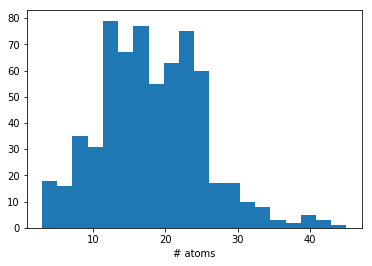

In [18]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.hist([len(item[-1]) for item in mol_top_sys_pos_list], bins=20);
plt.xlabel('# atoms')

In [225]:
mol, top, sys, pos = mol_top_sys_pos_list[-50]
sys.getForces()

[<simtk.openmm.openmm.HarmonicBondForce; proxy of <Swig Object of type 'OpenMM::HarmonicBondForce *' at 0x1216f7b10> >,
 <simtk.openmm.openmm.HarmonicAngleForce; proxy of <Swig Object of type 'OpenMM::HarmonicAngleForce *' at 0x1216f75d0> >,
 <simtk.openmm.openmm.PeriodicTorsionForce; proxy of <Swig Object of type 'OpenMM::PeriodicTorsionForce *' at 0x1216f7e40> >,
 <simtk.openmm.openmm.NonbondedForce; proxy of <Swig Object of type 'OpenMM::NonbondedForce *' at 0x1216f7270> >,
 <simtk.openmm.openmm.CMMotionRemover; proxy of <Swig Object of type 'OpenMM::CMMotionRemover *' at 0x1216f7660> >]

In [226]:
mol.GetEnergy()

0.8261666297912598

In [227]:
# create an implicit solvent force

from simtk import openmm as mm


def get_nb_force(system):
    forces = sys.getForces()
    for f in forces:
        if 'NonbondedForce' in f.__class__.__name__:
            return f
    raise(Exception('No nonbonded force found'))    

def construct_gbsa_force(system):
    nb_force = get_nb_force(system)
    
    gbsa = mm.GBSAOBCForce()
    for i in range(nb_force.getNumParticles()):
        charge = nb_force.getParticleParameters(i)[0]
        gbsa.addParticle(charge=charge, radius=1.0, scalingFactor=1.0)
    return gbsa

In [228]:
gbsa = construct_gbsa_force(sys)
gbsa.getSoluteDielectric(), gbsa.getSolventDielectric(), gbsa.getSurfaceAreaEnergy()

(1.0, 78.3, Quantity(value=2.25936, unit=kilojoule/(nanometer**2*mole)))

In [229]:
from simtk.openmm import app
from simtk import openmm as mm
from simtk import unit
from tqdm import tqdm

In [248]:
def get_vacuum_samples(topology, system, positions, n_samples=1000):
    vacuum_sim = app.Simulation(topology,
                         system,
                         mm.LangevinIntegrator(298 * unit.kelvin, 1.0 / unit.picosecond, 1.0 * unit.femtosecond),
                         platform=mm.Platform.getPlatformByName('Reference')
                        )
    vacuum_sim.context.setPositions(positions)
    vacuum_sim.context.setVelocitiesToTemperature(298 * unit.kelvin)
    vacuum_sim.minimizeEnergy()
    vacuum_sim.step(1000)

    vacuum_traj = []
    for _ in tqdm(range(n_samples)):
        vacuum_sim.step(1000)
        vacuum_traj.append(vacuum_sim.context.getState(getPositions=True).getPositions(asNumpy=True))
    
    return vacuum_sim, vacuum_traj

In [249]:
vacuum_sim, vacuum_traj = get_vacuum_samples(top, sys, pos)



  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 5/1000 [00:00<00:24, 41.28it/s]

  1%|          | 9/1000 [00:00<00:24, 39.80it/s]

  1%|▏         | 14/1000 [00:00<00:24, 40.07it/s]

  2%|▏         | 18/1000 [00:00<00:25, 39.00it/s]

  2%|▏         | 22/1000 [00:00<00:26, 37.45it/s]

  3%|▎         | 26/1000 [00:00<00:26, 37.08it/s]

  3%|▎         | 30/1000 [00:00<00:26, 36.07it/s]

  3%|▎         | 34/1000 [00:00<00:27, 35.45it/s]

  4%|▍         | 38/1000 [00:01<00:27, 34.82it/s]

  4%|▍         | 42/1000 [00:01<00:27, 34.46it/s]

  5%|▍         | 46/1000 [00:01<00:27, 34.28it/s]

  5%|▌         | 50/1000 [00:01<00:27, 34.06it/s]

  5%|▌         | 54/1000 [00:01<00:27, 33.93it/s]

  6%|▌         | 58/1000 [00:01<00:27, 34.00it/s]

  6%|▌         | 62/1000 [00:01<00:27, 33.89it/s]

  7%|▋         | 66/1000 [00:01<00:27, 33.65it/s]

  7%|▋         | 70/1000 [00:02<00:27, 33.64it/s]

  7%|▋         | 74/1000 [00:02<00:27, 33.56it/s]

  8%|▊         | 78/1000 [00:02<00:27, 3

 49%|████▉     | 491/1000 [00:17<00:17, 28.37it/s]

 50%|████▉     | 495/1000 [00:17<00:17, 28.39it/s]

 50%|████▉     | 499/1000 [00:17<00:17, 28.41it/s]

 50%|█████     | 503/1000 [00:17<00:17, 28.44it/s]

 51%|█████     | 507/1000 [00:17<00:17, 28.47it/s]

 51%|█████     | 511/1000 [00:17<00:17, 28.49it/s]

 52%|█████▏    | 515/1000 [00:18<00:17, 28.52it/s]

 52%|█████▏    | 519/1000 [00:18<00:16, 28.54it/s]

 52%|█████▏    | 523/1000 [00:18<00:16, 28.56it/s]

 53%|█████▎    | 527/1000 [00:18<00:16, 28.60it/s]

 53%|█████▎    | 531/1000 [00:18<00:16, 28.60it/s]

 54%|█████▎    | 535/1000 [00:18<00:16, 28.60it/s]

 54%|█████▍    | 539/1000 [00:18<00:16, 28.60it/s]

 54%|█████▍    | 543/1000 [00:18<00:15, 28.63it/s]

 55%|█████▍    | 547/1000 [00:19<00:15, 28.65it/s]

 55%|█████▌    | 551/1000 [00:19<00:15, 28.68it/s]

 56%|█████▌    | 555/1000 [00:19<00:15, 28.72it/s]

 56%|█████▌    | 559/1000 [00:19<00:15, 28.73it/s]

 56%|█████▋    | 563/1000 [00:19<00:15, 28.76it/s]

 57%|█████▋ 

In [250]:
sorted_smiles[-50]

'C=CCl'

In [251]:
len(pos)

6

In [252]:
mol_index = -1
for i in range(len(db)):
    if db[i][1] == sorted_smiles[-50]:
        print(i)
        mol_index = i
        break
print(db[i])

422
['mobley_6474572', 'C=CCl', 'chloroethylene', '-0.59', '0.60', '1.16', '0.02', '10.1021/ct050097l', '10.1021/ct800409d', 'Experimental uncertainty not presently available, so assigned a default value.  ']


In [253]:
legend

['# compound id (and file prefix)',
 'SMILES',
 'iupac name (or alternative if IUPAC is unavailable or not parseable by OEChem)',
 'experimental value (kcal/mol)',
 'experimental uncertainty (kcal/mol)',
 'Mobley group calculated value (GAFF) (kcal/mol)',
 'calculated uncertainty (kcal/mol)',
 'experimental reference (original or paper this value was taken from)',
 'calculated reference',
 'text notes.']

In [254]:
from openmmtools.constants import kB
temperature = 298 * unit.kelvin
beta = 1.0 / (kB * temperature)

In [255]:
from simtk import unit
experimental_value = beta * (float(db[mol_index][3]) * unit.kilocalorie_per_mole)
experimental_value

-0.9963059494075202

In [256]:
experimental_uncertainty = beta * (float(db[mol_index][4]) * unit.kilocalorie_per_mole)
experimental_uncertainty

1.0131924909229018

In [257]:
from copy import deepcopy
deepcopy(sys)

<simtk.openmm.openmm.System; proxy of <Swig Object of type 'OpenMM::System *' at 0x126b5c7b0> >

In [282]:
def create_implicit_sim(topology, system):
    """Implicit solvent will be force group 0, everything else will be force group 1"""
    gbsa = construct_gbsa_force(system)
    new_system = deepcopy(system)
    new_system.addForce(gbsa)
    
    implicit_sim = app.Simulation(topology,
                         new_system,
                         mm.LangevinIntegrator(298 * unit.kelvin, 1.0 / unit.picosecond, 1.0 * unit.femtosecond),
                         platform=mm.Platform.getPlatformByName('Reference')
                        )
    
    for force in implicit_sim.system.getForces():
        force.setForceGroup(1)
    
    gbsa.setForceGroup(0)

    return implicit_sim

In [283]:
sys.getForces()

[<simtk.openmm.openmm.HarmonicBondForce; proxy of <Swig Object of type 'OpenMM::HarmonicBondForce *' at 0x1227b2d20> >,
 <simtk.openmm.openmm.HarmonicAngleForce; proxy of <Swig Object of type 'OpenMM::HarmonicAngleForce *' at 0x1227b2b70> >,
 <simtk.openmm.openmm.PeriodicTorsionForce; proxy of <Swig Object of type 'OpenMM::PeriodicTorsionForce *' at 0x1227b2030> >,
 <simtk.openmm.openmm.NonbondedForce; proxy of <Swig Object of type 'OpenMM::NonbondedForce *' at 0x1227b20c0> >,
 <simtk.openmm.openmm.CMMotionRemover; proxy of <Swig Object of type 'OpenMM::CMMotionRemover *' at 0x1227b24b0> >]

In [284]:
implicit_sim = create_implicit_sim(top, sys)
implicit_sim.system.getForces()

[<simtk.openmm.openmm.HarmonicBondForce; proxy of <Swig Object of type 'OpenMM::HarmonicBondForce *' at 0x1227b2450> >,
 <simtk.openmm.openmm.HarmonicAngleForce; proxy of <Swig Object of type 'OpenMM::HarmonicAngleForce *' at 0x1227b2db0> >,
 <simtk.openmm.openmm.PeriodicTorsionForce; proxy of <Swig Object of type 'OpenMM::PeriodicTorsionForce *' at 0x1227b2180> >,
 <simtk.openmm.openmm.NonbondedForce; proxy of <Swig Object of type 'OpenMM::NonbondedForce *' at 0x1227b2090> >,
 <simtk.openmm.openmm.CMMotionRemover; proxy of <Swig Object of type 'OpenMM::CMMotionRemover *' at 0x1227b24e0> >,
 <simtk.openmm.openmm.GBSAOBCForce; proxy of <Swig Object of type 'OpenMM::GBSAOBCForce *' at 0x1227b2240> >]

In [287]:
gbsa = implicit_sim.system.getForces()[-1]

In [288]:
implicit_sim.context.setPositions(pos)

In [456]:
def get_implicit_u_diffs(implicit_sim, x):
    u_diff = np.zeros(len(x))

    for i in range(len(x)):
        #vacuum_sim.context.setPositions(x[i])
        implicit_sim.context.setPositions(x[i])
        
        
        # TODO: test where I ensure that the force-group hackery is giving me the same as this diff
        #U_implicit = implicit_sim.context.getState(getEnergy=True).getPotentialEnergy()
        #U_vacuum = vacuum_sim.context.getState(getEnergy=True).getPotentialEnergy()
        #u_diff[i] = beta * (U_implicit - U_vacuum)
        
        
        u_diff[i] = beta * implicit_sim.context.getState(getEnergy=True, groups={0}).getPotentialEnergy()
    return u_diff

In [457]:
implicit_sim.context.setPositions(vacuum_traj[-1])
state = implicit_sim.context.getState(getEnergy=True, groups={0})
state.getPotentialEnergy()

Quantity(value=62.0065698473681, unit=kilojoule/mole)

In [458]:
u_diffs = get_implicit_u_diffs(implicit_sim, vacuum_traj)
u_diffs

array([24.55100302, 25.32926768, 24.2515916 , 25.12661072, 24.61160572,
       24.90715661, 24.7950926 , 24.7111848 , 25.22526869, 25.0721567 ,
       25.21167786, 25.06442132, 25.411179  , 25.34349274, 25.26301535,
       25.62563043, 25.29828351, 25.00611594, 25.03955973, 25.55285827,
       25.33099769, 25.11233177, 25.43334128, 25.64230056, 24.70646924,
       25.7377613 , 24.77715849, 24.91432431, 25.12013858, 24.95354869,
       25.23932784, 25.06554519, 25.1599211 , 24.6740694 , 25.29871606,
       25.05782678, 25.45236886, 25.53727426, 25.58546984, 25.10967427,
       24.96905541, 24.80339806, 25.17867114, 26.29741297, 24.4954124 ,
       25.14928604, 25.06225443, 25.04071433, 25.29455559, 24.42688199,
       25.26085893, 25.40373181, 24.91306519, 24.75356534, 25.04919948,
       25.1495312 , 24.37727144, 25.50920003, 24.80097418, 26.1032125 ,
       24.79325496, 25.11119144, 24.5702981 , 24.81991169, 25.39411229,
       25.22579154, 24.82520953, 25.02214462, 25.28245931, 25.03

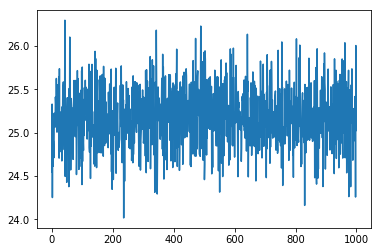

In [459]:
plt.plot(u_diffs)

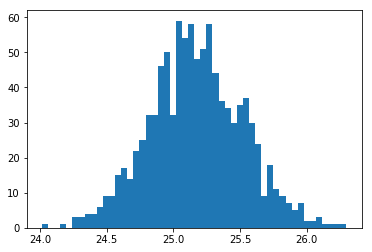

In [460]:
plt.hist(u_diffs, bins=50);

In [461]:
import pymbar
pymbar.EXP(u_diffs)

(25.11088393100738, 0.011307917312716924)

Text(0,0.5,'estimated $\\Delta F$')

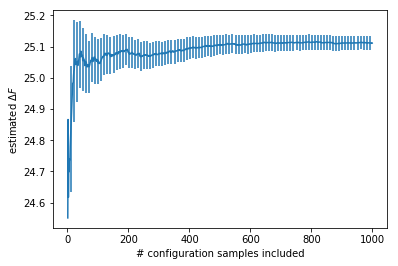

In [462]:
means, uncs = [], []
for i in range(1, len(u_diffs)):
    mean, unc = pymbar.EXP(u_diffs[:i])
    means.append(mean)
    uncs.append(unc)
means = np.array(means)
uncs = np.array(uncs)

plt.errorbar(range(1, 1 + len(means)), means, 1.96 * uncs, errorevery=10)
plt.xlabel('# configuration samples included')
plt.ylabel(r'estimated $\Delta F$')

In [463]:
means[-1], uncs[-1]

(25.110972909316175, 0.01131989368455899)

Text(0,0.5,'estimated $\\Delta F$')

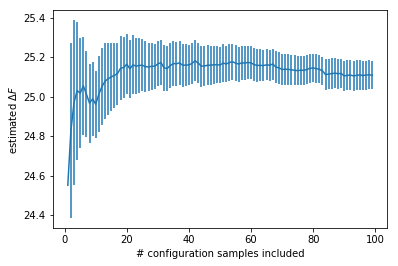

In [464]:
means, uncs = [], []
for i in range(1, len(u_diffs[::10])):
    mean, unc = pymbar.EXP(u_diffs[::10][:i])
    means.append(mean)
    uncs.append(unc)
means = np.array(means)
uncs = np.array(uncs)

plt.errorbar(range(1, 1 + len(means)), means, 1.96 * uncs, errorevery=1)
plt.xlabel('# configuration samples included')
plt.ylabel(r'estimated $\Delta F$')

In [465]:
means[-1], uncs[-1]

(25.107615315532755, 0.03659119012719574)

Text(0,0.5,'estimated $\\Delta F$')

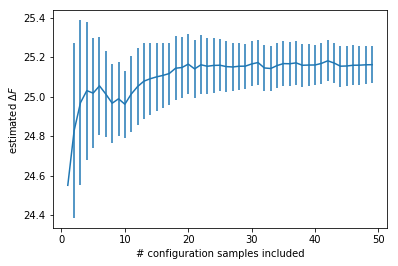

In [466]:
means, uncs = [], []
for i in range(1, len(u_diffs[::20])):
    mean, unc = pymbar.EXP(u_diffs[::10][:i])
    means.append(mean)
    uncs.append(unc)
means = np.array(means)
uncs = np.array(uncs)

plt.errorbar(range(1, 1 + len(means)), means, 1.96 * uncs, errorevery=1)
plt.xlabel('# configuration samples included')
plt.ylabel(r'estimated $\Delta F$')

Text(0,0.5,'estimated $\\Delta F$')

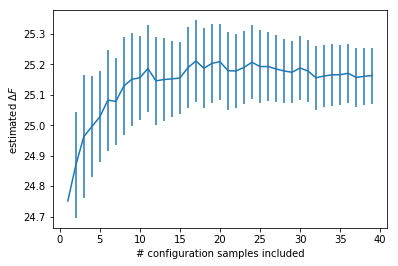

In [467]:
means, uncs = [], []
for i in range(1, len(u_diffs[200::20])):
    mean, unc = pymbar.EXP(u_diffs[200::20][:i])
    means.append(mean)
    uncs.append(unc)
means = np.array(means)
uncs = np.array(uncs)

plt.errorbar(range(1, 1 + len(means)), means, 1.96 * uncs, errorevery=1)
plt.xlabel('# configuration samples included')
plt.ylabel(r'estimated $\Delta F$')

Text(0,0.5,'estimated $\\Delta F$')

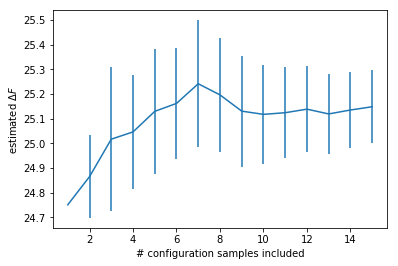

In [468]:
means, uncs = [], []
for i in range(1, len(u_diffs[200::50])):
    mean, unc = pymbar.EXP(u_diffs[200::50][:i])
    means.append(mean)
    uncs.append(unc)
means = np.array(means)
uncs = np.array(uncs)

plt.errorbar(range(1, 1 + len(means)), means, 1.96 * uncs, errorevery=1)
plt.xlabel('# configuration samples included')
plt.ylabel(r'estimated $\Delta F$')

In [469]:
means[-1], uncs[-1]

(25.14791730320181, 0.07594626258992512)

In [470]:
len(u_diffs)

1000

In [471]:
def get_gbsa_force(system):
    for force in system.getForces():
        if "GBSA" in force.__class__.__name__:
            return force
    raise(Exception('No GBSA force found'))

In [472]:
get_gbsa_force(implicit_sim.context.getSystem())

<simtk.openmm.openmm.GBSAOBCForce; proxy of <Swig Object of type 'OpenMM::GBSAOBCForce *' at 0x12280e150> >

In [473]:
def predict_solvation_free_energy(theta, thinning=50, burn_in=200):
    radii, scaling_factors = theta[:int(len(theta) / 2)], theta[int(len(theta) / 2):]
    gbsa = get_gbsa_force(implicit_sim.context.getSystem())
    
    for i in range(len(radii)):
        charge = gbsa.getParticleParameters(i)[0]
        gbsa.setParticleParameters(index=i,
                                   charge=charge,
                                   radius=radii[i],
                                   scalingFactor=scaling_factors[i],
                                  )
    
    gbsa.updateParametersInContext(implicit_sim.context)
    u_diffs = get_implicit_u_diffs(implicit_sim, vacuum_traj[burn_in::thinning])
    mean, unc = pymbar.EXP(u_diffs)
    
    return mean, unc

def log_likelihood(theta, thinning=50, burn_in=200):
    """theta includes radii and scaling factors"""

    mean, unc = predict_solvation_free_energy(theta, thinning=20, burn_in=burn_in)
    
    return - (mean - experimental_value)**2 / (unc * experimental_uncertainty)

```force = sim.context.getSystem().getForce(0)
force.setParticleParameters( ... )
force.updateParametersInContext(sim.context)```

Gives this exception:
```Exception: getImplInContext: This Force is not present in the Context```

Suspicion: this is because I removed the nonbonded force... Going to work around this by, instead of creating an implicit-only sim, using a force group to index into the implicit solvent force

In [474]:
implicit_sim.context.getSystem().getForces()

[<simtk.openmm.openmm.HarmonicBondForce; proxy of <Swig Object of type 'OpenMM::HarmonicBondForce *' at 0x122813300> >,
 <simtk.openmm.openmm.HarmonicAngleForce; proxy of <Swig Object of type 'OpenMM::HarmonicAngleForce *' at 0x122813ba0> >,
 <simtk.openmm.openmm.PeriodicTorsionForce; proxy of <Swig Object of type 'OpenMM::PeriodicTorsionForce *' at 0x1228134b0> >,
 <simtk.openmm.openmm.NonbondedForce; proxy of <Swig Object of type 'OpenMM::NonbondedForce *' at 0x122813750> >,
 <simtk.openmm.openmm.CMMotionRemover; proxy of <Swig Object of type 'OpenMM::CMMotionRemover *' at 0x122813e40> >,
 <simtk.openmm.openmm.GBSAOBCForce; proxy of <Swig Object of type 'OpenMM::GBSAOBCForce *' at 0x1277e3b40> >]

In [475]:
implicit_sim.system.getForces()

[<simtk.openmm.openmm.HarmonicBondForce; proxy of <Swig Object of type 'OpenMM::HarmonicBondForce *' at 0x122801f90> >,
 <simtk.openmm.openmm.HarmonicAngleForce; proxy of <Swig Object of type 'OpenMM::HarmonicAngleForce *' at 0x122801450> >,
 <simtk.openmm.openmm.PeriodicTorsionForce; proxy of <Swig Object of type 'OpenMM::PeriodicTorsionForce *' at 0x122801a80> >,
 <simtk.openmm.openmm.NonbondedForce; proxy of <Swig Object of type 'OpenMM::NonbondedForce *' at 0x122801b70> >,
 <simtk.openmm.openmm.CMMotionRemover; proxy of <Swig Object of type 'OpenMM::CMMotionRemover *' at 0x1228018a0> >,
 <simtk.openmm.openmm.GBSAOBCForce; proxy of <Swig Object of type 'OpenMM::GBSAOBCForce *' at 0x122801330> >]

In [476]:
def log_prior(theta):
    if np.min(theta) <= 0:
        return - np.inf
    else:
        return 0

In [477]:
theta0 = np.ones(len(pos) * 2)

In [480]:
%%time
log_likelihood(theta0)

CPU times: user 3.49 ms, sys: 278 µs, total: 3.77 ms
Wall time: 3.52 ms


-14611.284147034119

In [481]:
%%prun
log_likelihood(theta0)

In [482]:
len(theta0)

12

In [483]:
def log_prob(theta):
    return log_prior(theta) + log_likelihood(theta)

In [379]:
cov = np.eye(len(theta0))

In [380]:
from emcee import MHSampler
mh_sampler = MHSampler(cov=cov, dim=len(theta0), lnprobfn=log_prob)

In [381]:
mh_result = mh_sampler.run_mcmc(theta0, 1000)

/Users/joshuafass/anaconda/lib/python3.6/site-packages/numpy/core/_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)


In [382]:
mh_sampler.acceptance_fraction

0.007

In [484]:
def random_walk_mh(x0, log_prob_fun, n_steps=1000, stepsize=0.1):
    
    dim = len(x0)
    
    traj = [x0]
    log_probs = [log_prob_fun(x0)]
    
    acceptances = 0
    r = range(n_steps)
    #trange = tqdm(r)
    for n in r:
    #for n in trange:
        
        x_proposal = traj[-1] + stepsize * np.random.randn(dim)
        log_prob_proposal = log_prob_fun(x_proposal)
        
        if np.random.rand() < np.exp(log_prob_proposal - log_probs[-1]):
            traj.append(x_proposal)
            log_probs.append(log_prob_proposal)
            acceptances += 1
        else:
            traj.append(traj[-1])
            log_probs.append(log_probs[-1])
        
        #trange.set_postfix({'log_prob': log_probs[-1], 'accept_fraction': float(acceptances) / (1 + n)})
    #del(trange)
    
    return np.array(traj), np.array(log_probs), float(acceptances) / n_steps

In [486]:
traj, log_probs, acceptance_fraction = random_walk_mh(theta0, log_prob, n_steps=10000, stepsize=0.1)
acceptance_fraction

/Users/joshuafass/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: overflow encountered in exp


0.002

In [491]:
traj[-1]

array([0.84310658, 0.7781776 , 0.62258909, 0.91622712, 0.85665935,
       0.9970443 , 0.98059338, 1.07311222, 1.48139463, 1.40070802,
       1.64431576, 0.56315956])

In [492]:
predict_solvation_free_energy(traj[-1])

(-0.9871862490152785, 0.0012898458757242192)

In [493]:
predict_solvation_free_energy(traj[0])

(25.128996187859933, 0.07218369369208466)

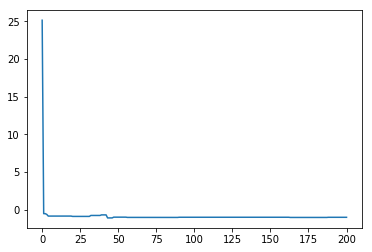

In [494]:
plt.plot([predict_solvation_free_energy(t)[0] for t in traj[::50]])

In [495]:
experimental_value, experimental_uncertainty

(-0.9963059494075202, 1.0131924909229018)

In [496]:
traj[100]

array([0.99154751, 0.77227134, 1.06138432, 1.1066105 , 1.09773935,
       1.09214713, 1.29599436, 0.99412622, 1.00141478, 1.08262172,
       1.24695783, 1.25189334])

In [497]:
log_probs[-1] - log_probs[0]

14611.21704308429

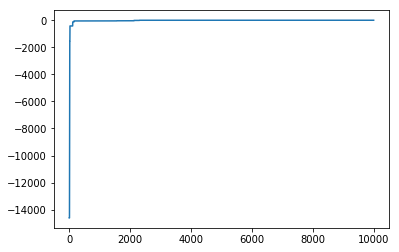

In [498]:
plt.plot(log_probs)

In [499]:
acceptance_fraction

0.002

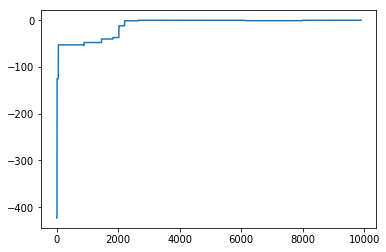

In [500]:
plt.plot(log_probs[100:])

In [501]:
burned_in_theta0 = traj[-1]

In [502]:
np.linalg.norm(burned_in_theta0 - theta0)

1.1170653414577945

In [503]:
traj, log_probs, acceptance_fraction = random_walk_mh(burned_in_theta0, log_prob, n_steps=10000, stepsize=0.01)
acceptance_fraction

0.3293

In [504]:
np.linalg.norm(traj[-1] - traj[0])

1.0758783954265987

In [505]:
traj.shape

(10001, 12)

In [506]:
traj[-1]

array([0.81471906, 0.75581512, 0.7338147 , 0.84813375, 0.89034828,
       0.98605464, 0.05332992, 1.11356716, 1.07013399, 1.56218764,
       1.423029  , 0.38340447])

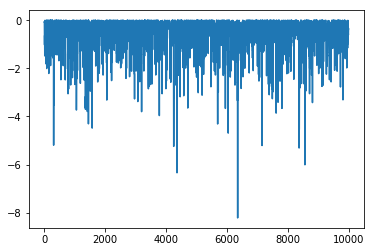

In [507]:
plt.plot(log_probs)

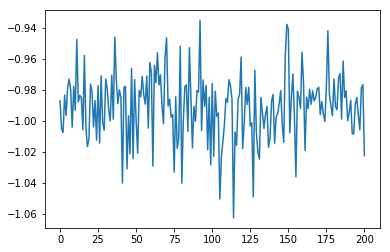

In [508]:
plt.plot([predict_solvation_free_energy(t)[0] for t in traj[::50]])

In [509]:
import pyemma
tica = pyemma.coordinates.tica(traj)

In [510]:
tica_traj = tica.get_output()[0]

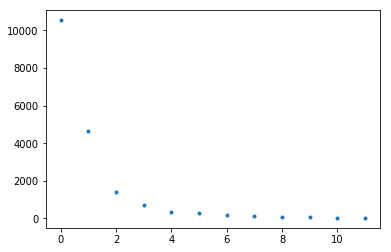

In [511]:
plt.plot(tica.timescales, '.')

In [514]:
tica.timescales[0]

10528.178829683455

In [512]:
# okay, so the mixing time is at least 10000 steps -- probably more

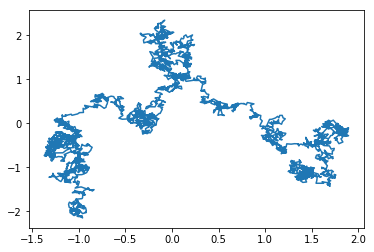

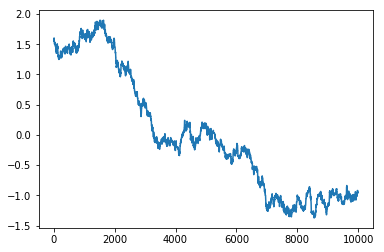

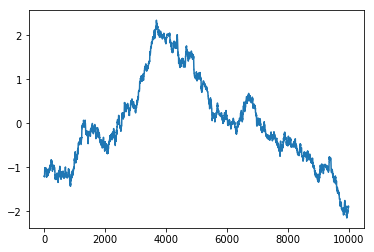

In [518]:
plt.plot(tica_traj[:,0], tica_traj[:,1])
plt.figure()
plt.plot(tica_traj[:,0])
plt.figure()
plt.plot(tica_traj[:,1])

In [522]:
traj, log_probs, acceptance_fraction = random_walk_mh(burned_in_theta0, log_prob, n_steps=100000, stepsize=0.02)
acceptance_fraction

/Users/joshuafass/anaconda/lib/python3.6/site-packages/numpy/core/_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)
/Users/joshuafass/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:24: RuntimeWarning: divide by zero encountered in double_scalars


0.05647

[71580.27529987 15006.96090422 12338.43242927  6210.0792189
  4440.20427924  3654.23433517  2007.42702003  1597.67829588
  1502.28698608  1043.9849       650.1518352    466.38662156]


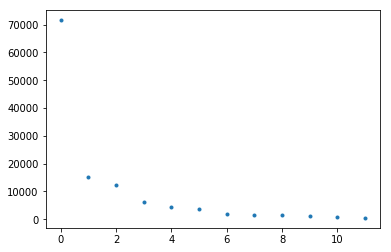

In [523]:
tica = pyemma.coordinates.tica(traj)
tica_traj = tica.get_output()[0]
plt.plot(tica.timescales, '.')
print(tica.timescales)

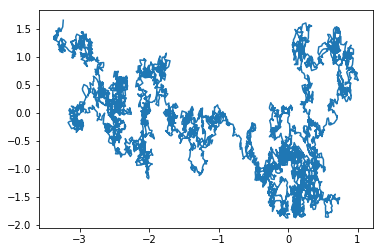

In [524]:
plt.plot(tica_traj[:,0], tica_traj[:,1])

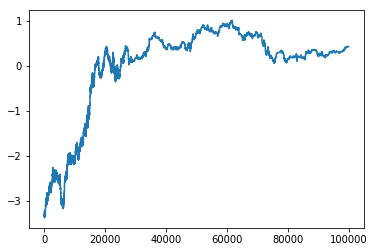

In [525]:
plt.plot(tica_traj[:,0])

In [526]:
traj_smallstep, log_probs_small_step, acceptance_fraction_small_step = random_walk_mh(burned_in_theta0, log_prob, n_steps=100000, stepsize=0.01)
acceptance_fraction_small_step

/Users/joshuafass/anaconda/lib/python3.6/site-packages/numpy/core/_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)
/Users/joshuafass/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:24: RuntimeWarning: divide by zero encountered in double_scalars


0.15461

[123609.45642504  24191.29583212  10581.02897678   7717.8182963
   4828.07732292   4021.370178     2706.88753045   1692.77569636
   1638.85912773    955.28587036    791.26672608    492.04124319]
biggest timescale: 123609.45642504038


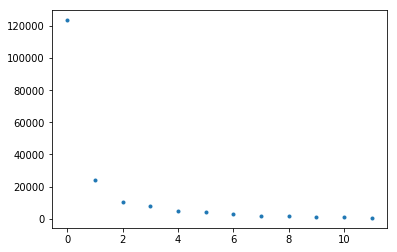

In [527]:
tica = pyemma.coordinates.tica(traj_smallstep)
tica_traj = tica.get_output()[0]
plt.plot(tica.timescales, '.')
print(tica.timescales)
print('biggest timescale: ' + str(tica.timescales[0]))

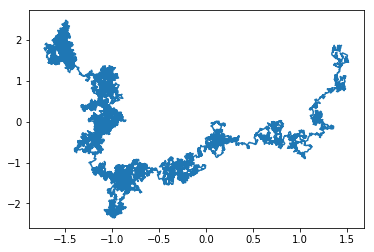

In [528]:
plt.plot(tica_traj[:,0], tica_traj[:,1])

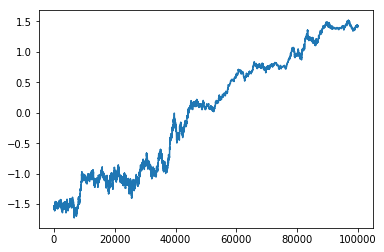

In [529]:
plt.plot(tica_traj[:,0])

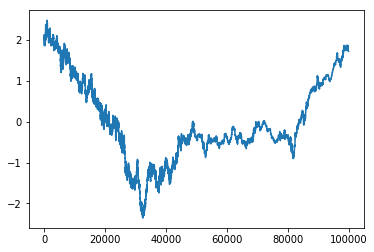

In [530]:
plt.plot(tica_traj[:,1])

In [531]:
traj[-1], traj.shape

(array([0.72848283, 0.03202714, 0.15604428, 0.73674816, 0.56274366,
        0.02781859, 0.10339416, 0.25325179, 0.49882474, 0.31807538,
        3.83076147, 2.12382447]), (100001, 12))

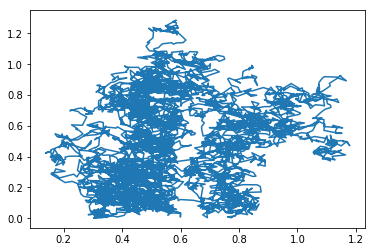

In [532]:
plt.plot(traj[:,0], traj[:,6])

[31478.39432744  5751.00325721  3620.75567462  2937.67772746
  1553.32586545  1157.23436838]
biggest timescale: 31478.394327443904


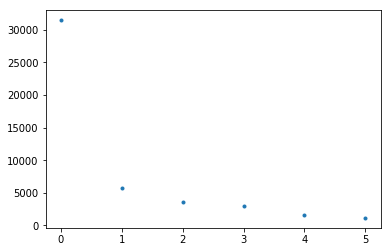

In [533]:
tica = pyemma.coordinates.tica(traj_smallstep[:, :6])
tica_traj = tica.get_output()[0]
plt.plot(tica.timescales, '.')
print(tica.timescales)
print('biggest timescale: ' + str(tica.timescales[0]))

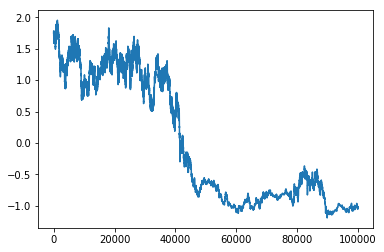

In [534]:
plt.plot(tica_traj[:,0])

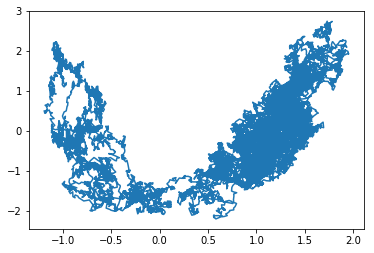

In [535]:
plt.plot(tica_traj[:,0], tica_traj[:,1])

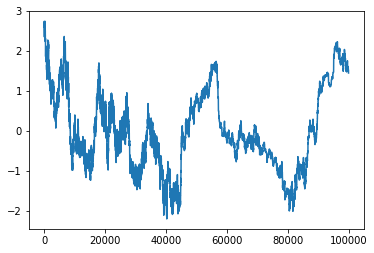

In [536]:
plt.plot(tica_traj[:,1])

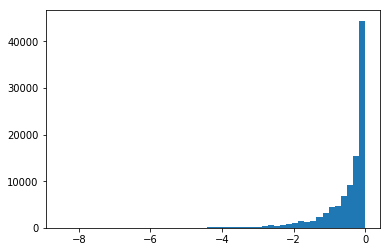

In [537]:
plt.hist(log_probs_small_step, bins=50);

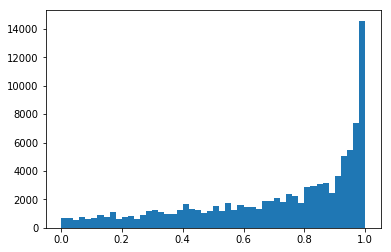

In [538]:
plt.hist(np.exp(log_probs_small_step), bins=50);

In [539]:
posterior_predictions = [predict_solvation_free_energy(t)[0] for t in traj_smallstep[::50]]

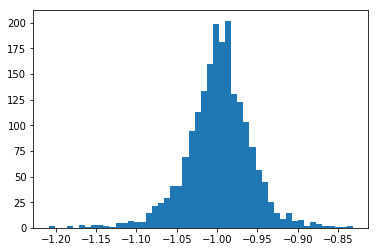

In [540]:
plt.hist(posterior_predictions, bins=50);

In [548]:
import mdtraj as md
md_top = md.Topology().from_openmm(top)
atom_names = [a.name for a in md_top.atoms]

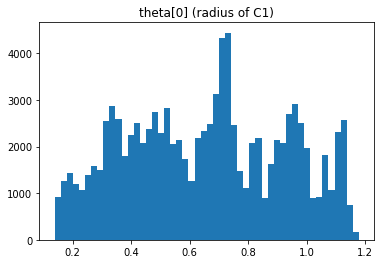

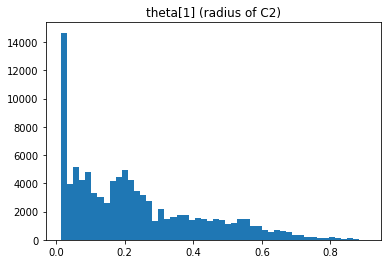

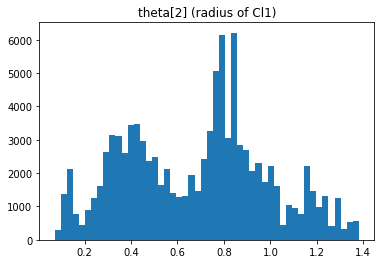

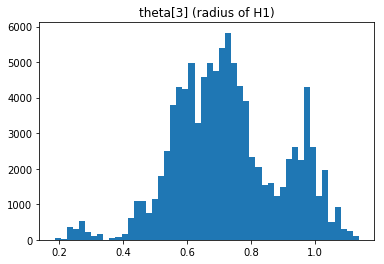

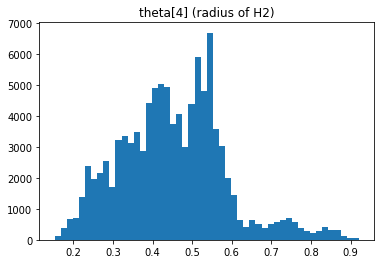

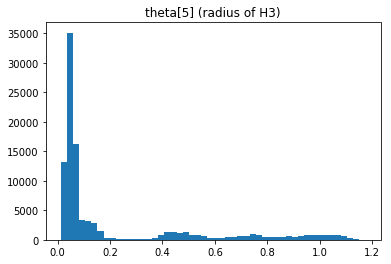

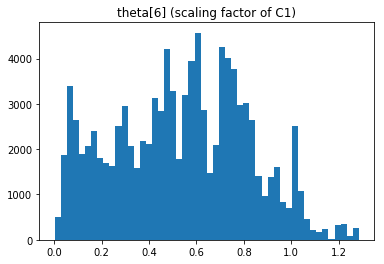

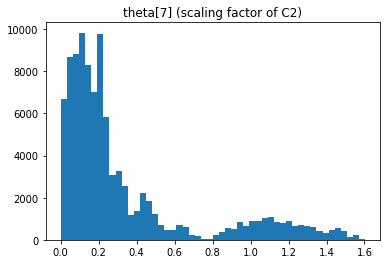

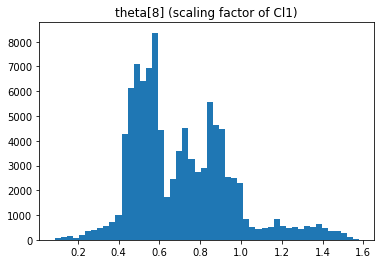

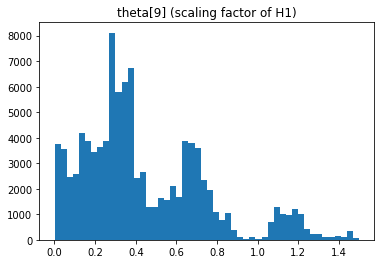

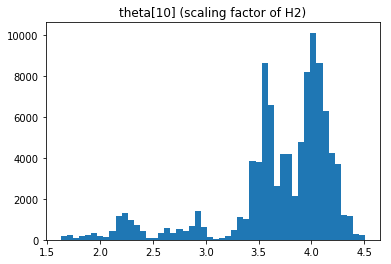

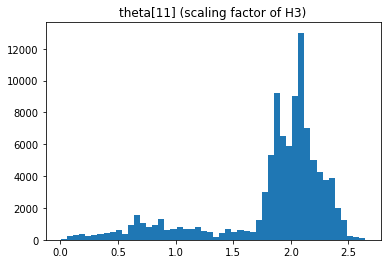

In [550]:
for i in range(traj.shape[1]):
    plt.figure()
    plt.hist(traj[:,i], bins=50)
    if i < (traj.shape[1] / 2):
        name = 'radius'
    else:
        name = 'scaling factor'
    plt.title('theta[{}] ({} of {})'.format(i, name, atom_names[int(i % len(atom_names))]))

In [551]:
# continuing the trajectory from above...
traj_extended, log_probs_extended, acceptance_fraction_extended = random_walk_mh(traj[-1], log_prob, n_steps=500000, stepsize=0.02)
acceptance_fraction_extended

/Users/joshuafass/anaconda/lib/python3.6/site-packages/numpy/core/_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)
/Users/joshuafass/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:24: RuntimeWarning: divide by zero encountered in double_scalars


0.021564

In [552]:
traj_long = np.vstack([traj, traj_extended])

In [553]:
len(traj_long)

600002

In [555]:
from sklearn.decomposition import PCA
pca = PCA()
pca.fit(traj_long)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

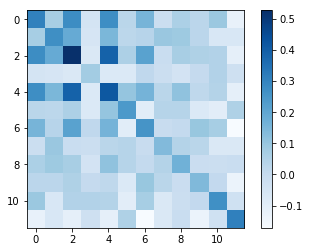

In [558]:
plt.imshow(pca.get_covariance(), cmap='Blues')
plt.colorbar()

[267306.80079943 127925.05359979  76913.16689355  43181.25170222
  35322.13605802  23122.94842696  17838.626855    14400.38754479
  11024.54395104   7835.74743245   6325.33754348   4361.98527232]
biggest timescale: 267306.80079942616


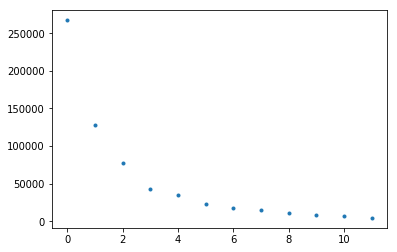

In [581]:
tica = pyemma.coordinates.tica(traj_long)
tica_traj = tica.get_output()[0]
plt.plot(tica.timescales, '.')
print(tica.timescales)
print('biggest timescale: ' + str(tica.timescales[0]))

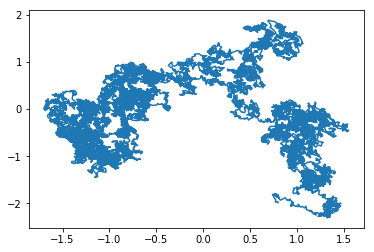

In [578]:
plt.plot(tica_traj[:,0], tica_traj[:,1])

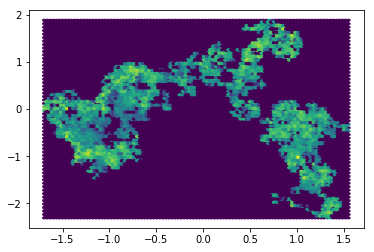

In [579]:
plt.hexbin(tica_traj[:,0], tica_traj[:,1], bins='log')

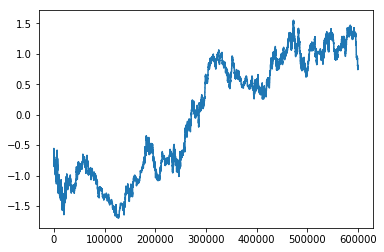

In [580]:
plt.plot(tica_traj[:,0])

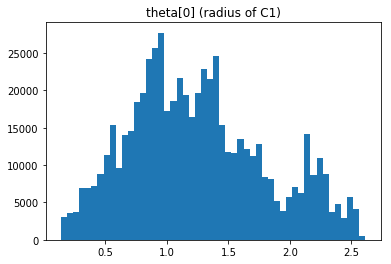

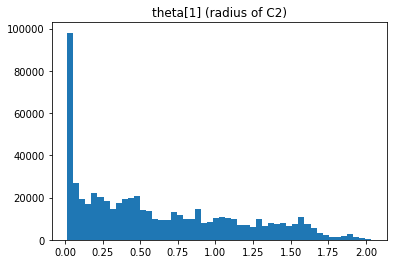

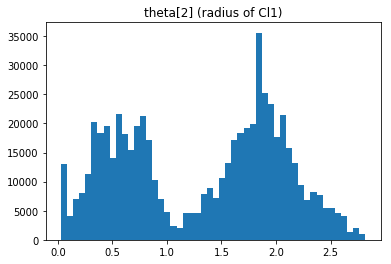

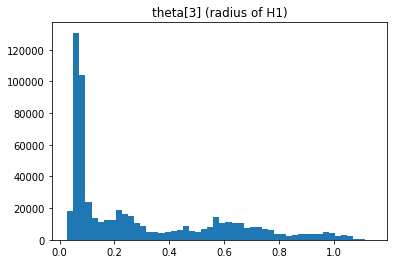

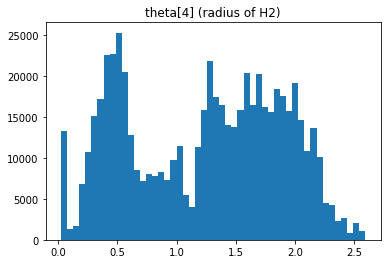

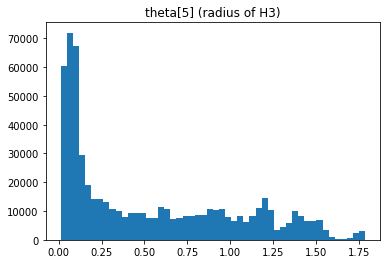

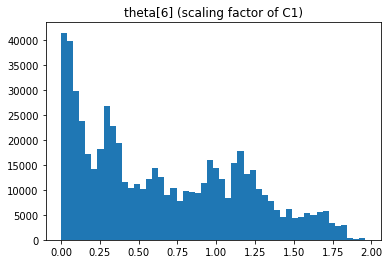

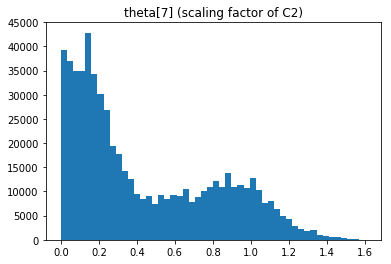

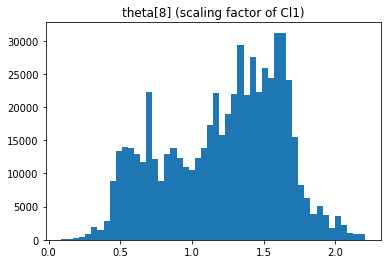

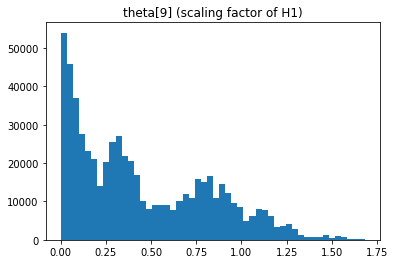

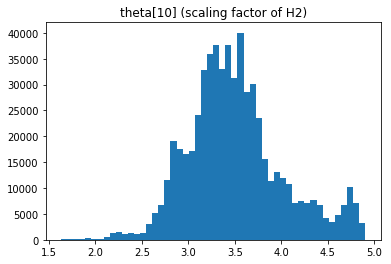

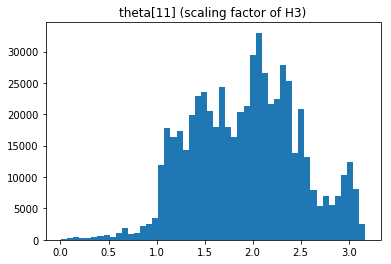

In [584]:
for i in range(traj.shape[1]):
    plt.figure()
    plt.hist(traj_long[:,i], bins=50)
    if i < (traj.shape[1] / 2):
        name = 'radius'
    else:
        name = 'scaling factor'
    plt.title('theta[{}] ({} of {})'.format(i, name, atom_names[int(i % len(atom_names))]))

Okay next up: summarizing this as 

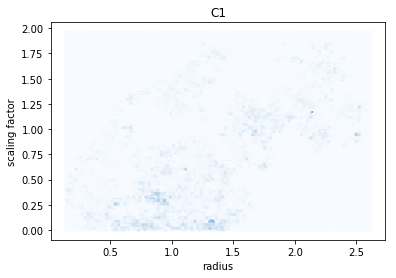

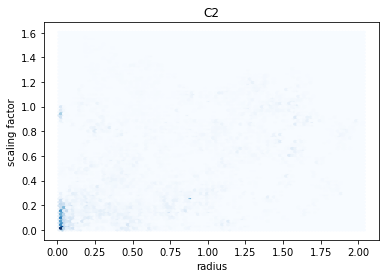

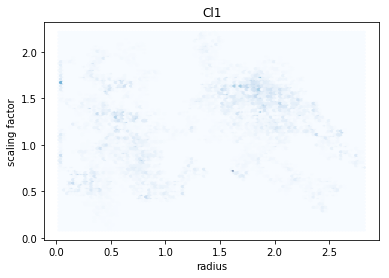

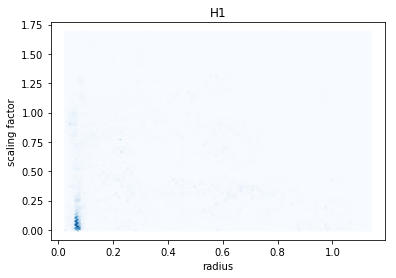

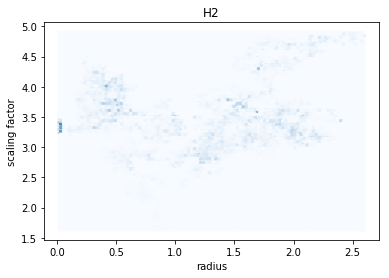

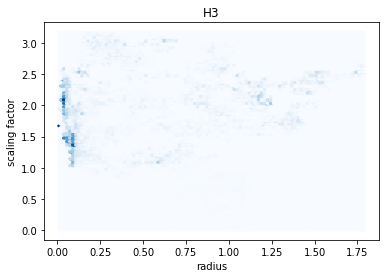

In [585]:
n_atoms = len(atom_names)
for i in range(len(atom_names)):
    plt.figure()
    plt.hexbin(traj_long[:,i], traj_long[:,i + n_atoms], cmap='Blues')
    plt.xlabel('radius')
    plt.ylabel('scaling factor')
    plt.title(atom_names[i])

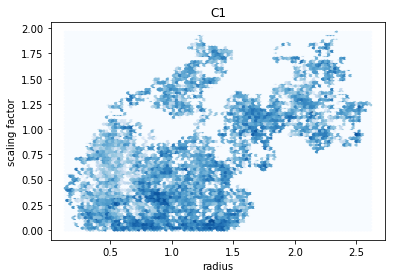

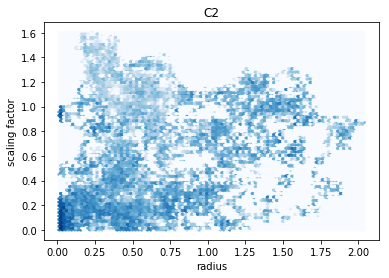

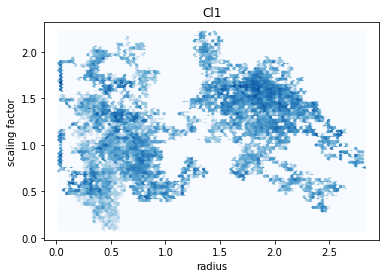

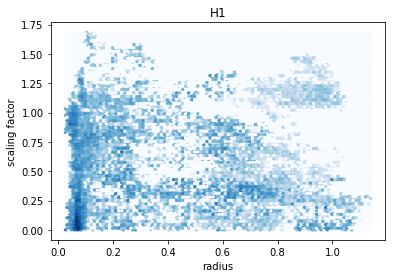

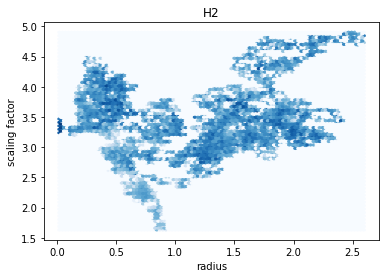

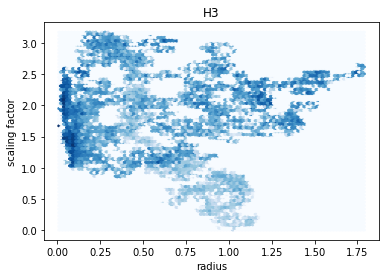

In [586]:
n_atoms = len(atom_names)
for i in range(len(atom_names)):
    plt.figure()
    plt.hexbin(traj_long[:,i], traj_long[:,i + n_atoms], cmap='Blues', bins='log')
    plt.xlabel('radius')
    plt.ylabel('scaling factor')
    plt.title(atom_names[i])

In [ ]:
# continuing the trajectory from above...
traj_extended, log_probs_extended, acceptance_fraction_extended = random_walk_mh(traj[-1], log_prob, n_steps=500000, stepsize=0.02)
acceptance_fraction_extended